In [1]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

Shelling Agent Definition

In [2]:
class SchellingAgent(mesa.Agent):
    def __init__(self, unique_id, model, agent_type, subtype, tolerance, move_strategy):
        super().__init__(unique_id, model)
        self.type = agent_type  # Red/Blue
        self.subtype = subtype  # Light/Pale/Dark
        self.tolerance = tolerance  #Tolerance of the agent
        self.satisfaction = 0  # Initialize satisfaction
        self.diversity = 0  # Initialize diversity
        self.move_strategy = move_strategy

    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True)  # Moore's neighbors
        total_neighbors = len(neighbors)

        # Calculate similar subtypes and different types 
        subtype_same = sum(1 for n in neighbors if n.subtype == self.subtype)  # Similar subtypes
        type_different = sum(1 for n in neighbors if n.type != self.type)  # Different types

        # Satisfaction (based on similar subtypes)
        if total_neighbors > 0:
            self.satisfaction = subtype_same / total_neighbors
        else:
            self.satisfaction = 0  # Maximum satisfaction if no neighbors

        # Diversity (based on different types)
        if total_neighbors > 0:
            self.diversity = type_different / total_neighbors
        else:
            self.diversity = 0  # No diversity if no neighbors

        # Move if diversity is higher than the agent's tolerance
        if self.diversity > self.tolerance:
            self.move()

    def move(self):
        # Move Randomly
        old_position = self.pos  # Store the old position

        if self.move_strategy == "Random":
            new_position = self.random.choice(list(self.model.grid.empties))
            self.model.grid.move_agent(self, new_position)

        # Move to a Random Cell with Higher Satisfaction
        elif self.move_strategy == "Higher Satisfaction":
            satisfaction_current = self.satisfaction
            empty_cells = list(self.model.grid.empties)  # Convert set to list
            cell_higher_satisfaction = []

            for empty_cell in empty_cells:
                self.model.grid.move_agent(self, empty_cell)
                neighbors = self.model.grid.get_neighbors(empty_cell, moore=True)
                subtype_sametypes = sum(1 for n in neighbors if n.subtype == self.subtype)
                total_neighbors = len(neighbors)
                new_satisfaction = subtype_sametypes / total_neighbors if total_neighbors > 0 else 1
                self.model.grid.move_agent(self, old_position)
                
                if new_satisfaction > satisfaction_current:
                    cell_higher_satisfaction.append(empty_cell)

            if cell_higher_satisfaction:
                new_position = self.random.choice(cell_higher_satisfaction)
                self.model.grid.move_agent(self, new_position)
            else:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)

        # Move to the Nearest Cell with Higher Satisfaction
        elif self.move_strategy == "Nearest Higher Satisfaction":
            satisfaction_current = self.satisfaction
            empty_cells = list(self.model.grid.empties)  # Convert set to list
            best_cell = None
            best_distance = float('inf')

            for empty_cell in empty_cells:
                self.model.grid.move_agent(self, empty_cell)
                neighbors = self.model.grid.get_neighbors(empty_cell, moore=True)
                subtype_sametypes = sum(1 for n in neighbors if n.subtype == self.subtype)
                total_neighbors = len(neighbors)
                new_satisfaction = subtype_sametypes / total_neighbors if total_neighbors > 0 else 1
                distance = abs(empty_cell[0] - self.pos[0]) + abs(empty_cell[1] - self.pos[1])
                self.model.grid.move_agent(self, self.pos)

                if new_satisfaction > satisfaction_current and distance < best_distance:
                    best_cell = empty_cell
                    best_distance = distance

            if best_cell:
                self.model.grid.move_agent(self, best_cell)
            else:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)

        # Check if the agent has moved
        if self.pos != old_position:
            self.model.moved = True  # Mark that an agent moved


Shelling Model Definition

In [3]:
class SchellingModel(mesa.Model):
    def __init__(self, width, height, density, society_type, move_strategy):
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.move_strategy = move_strategy
        self.distribute_agents(density, society_type)

    def distribute_agents(self, density, society_type):
        total_cells = self.grid.width * self.grid.height
        total_agents = int(total_cells * density)
        
        # Subtype distribution based on society type
        if society_type == "Tolerant":
            light_percent, pale_percent, dark_percent = 0.5, 0.25, 0.25
        elif society_type == "Neutral":
            light_percent, pale_percent, dark_percent = 0.25, 0.5, 0.25
        else:  # Intolerant
            light_percent, pale_percent, dark_percent = 0.25, 0.25, 0.5

        red_agents = total_agents // 2  # Assuming 50-50 split 
        blue_agents = total_agents - red_agents

        red_light = int(red_agents * light_percent)
        red_pale = int(red_agents * pale_percent)
        red_dark = red_agents - red_light - red_pale

        blue_light = int(blue_agents * light_percent)
        blue_pale = int(blue_agents * pale_percent)
        blue_dark = blue_agents - blue_light - blue_pale

        # Create agents based on calculated subtypes
        agents = []
        for _ in range(red_light):
            agents.append(("Red", "Light", 0.75))
        for _ in range(red_pale):
            agents.append(("Red", "Pale", 0.5))
        for _ in range(red_dark):
            agents.append(("Red", "Dark", 0.25))
        for _ in range(blue_light):
            agents.append(("Blue", "Light", 0.75))
        for _ in range(blue_pale):
            agents.append(("Blue", "Pale", 0.5))
        for _ in range(blue_dark):
            agents.append(("Blue", "Dark", 0.25))

        # Shuffle agents 
        self.random.shuffle(agents)
        empty_cells = list(self.grid.empties)
        self.random.shuffle(empty_cells)

        for (agent_type, subtype, tolerance), pos in zip(agents, empty_cells[:total_agents]):
            agent = SchellingAgent(pos, self, agent_type, subtype, tolerance, self.move_strategy)
            self.grid.place_agent(agent, pos)
            self.schedule.add(agent)

    def reset(self, width, height, density, society_type, move_strategy):  # Resetting for different runs
        self.__init__(width, height, density, society_type, move_strategy)

    def step(self):
        self.moved = False  # Movement flag
        self.schedule.step()  # All agents take a step
        return self.moved  # Return whether at least one agent moved

    def compute_satisfaction_avg(self):
        total_satisfaction = 0
        satisfied_agents = 0  # Count of satisfied agents
        
        for agent in self.schedule.agents:
            total_satisfaction += agent.satisfaction
            if agent.satisfaction > 0.4:
                satisfied_agents += 1
        
        satisfaction_avg = total_satisfaction / len(self.schedule.agents) if len(self.schedule.agents) > 0 else 0
        return satisfaction_avg, satisfied_agents  
    def compute_satisfaction_avg_by_subtype(self):
        # average satisfaction for each subtype
        subtype_satisfaction = {
            "Light Red": [], "Pale Red": [], "Dark Red": [],
            "Light Blue": [], "Pale Blue": [], "Dark Blue": []
        }
        
        for agent in self.schedule.agents:
            if agent.type == "Red":
                if agent.subtype == "Light":
                    subtype_satisfaction["Light Red"].append(agent.satisfaction)
                elif agent.subtype == "Pale":
                    subtype_satisfaction["Pale Red"].append(agent.satisfaction)
                elif agent.subtype == "Dark":
                    subtype_satisfaction["Dark Red"].append(agent.satisfaction)
            elif agent.type == "Blue":
                if agent.subtype == "Light":
                    subtype_satisfaction["Light Blue"].append(agent.satisfaction)
                elif agent.subtype == "Pale":
                    subtype_satisfaction["Pale Blue"].append(agent.satisfaction)
                elif agent.subtype == "Dark":
                    subtype_satisfaction["Dark Blue"].append(agent.satisfaction)

        
        satisfaction_avg = []
        for subtype, satisfaction_values in subtype_satisfaction.items():
            if satisfaction_values:
                satisfaction_avg.append(np.mean(satisfaction_values))
            else:
                satisfaction_avg.append(0)  # If there are no agents of this subtype

        return satisfaction_avg
    def compute_homophily(self):
        red_type_homophily_sum = 0
        blue_type_homophily_sum = 0
        red_type_count = 0
        blue_type_count = 0
        
        light_subtype_homophily_sum = 0
        pale_subtype_homophily_sum = 0
        dark_subtype_homophily_sum = 0
        light_subtype_count = 0
        pale_subtype_count = 0
        dark_subtype_count = 0

        for agent in self.schedule.agents:
            agent_diversity = agent.diversity  # Access diversity directly from the agent

            # Type-specific homophily (Red or Blue)
            if agent.type == "Red":
                red_type_homophily_sum += agent_diversity
                red_type_count += 1
            elif agent.type == "Blue":
                blue_type_homophily_sum += agent_diversity
                blue_type_count += 1

            # Subtype-specific homophily (Light, Pale, Dark)
            if agent.subtype == "Light":
                light_subtype_homophily_sum += agent.diversity
                light_subtype_count += 1
            elif agent.subtype == "Pale":
                pale_subtype_homophily_sum += agent.diversity
                pale_subtype_count += 1
            elif agent.subtype == "Dark":
                dark_subtype_homophily_sum += agent.diversity
                dark_subtype_count += 1

        # Average homophily for types
        avg_red_type_homophily = (red_type_homophily_sum / red_type_count) if red_type_count > 0 else 0
        avg_blue_type_homophily = (blue_type_homophily_sum / blue_type_count) if blue_type_count > 0 else 0
        
        # Average homophily for subtypes
        avg_light_subtype_homophily = (light_subtype_homophily_sum / light_subtype_count) if light_subtype_count > 0 else 0
        avg_pale_subtype_homophily = (pale_subtype_homophily_sum / pale_subtype_count) if pale_subtype_count > 0 else 0
        avg_dark_subtype_homophily = (dark_subtype_homophily_sum / dark_subtype_count) if dark_subtype_count > 0 else 0

        return (
            avg_red_type_homophily, avg_blue_type_homophily,
            avg_light_subtype_homophily, avg_pale_subtype_homophily, avg_dark_subtype_homophily
        )

    def compute_overall_homophily(self):
        #overall homophily
        total_diversity_sum = 0
        total_agents = len(self.schedule.agents)

        for agent in self.schedule.agents:
            total_diversity_sum += agent.diversity  

        overall_homophily = total_diversity_sum / total_agents if total_agents > 0 else 0
        return overall_homophily


Hitmap creation for Patterns

In [4]:
def plot_grid_state(grid, title, ax, legend=True):
    colors = ['#FFFFFF',  # Empty 
              '#ADD8E6',  # Light Blue
              '#87CEEB',  # Pale Blue
              '#00008B',  # Dark Blue
              '#FFB6C1',  # Light Red
              '#FA8072',  # Pale Red
              '#8B0000']  # Dark Red
              
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    
    grid_matrix = np.full((grid.width, grid.height), np.nan)  
    
    
    for (content, pos) in grid.coord_iter():
        x, y = pos
        if content:  # If the cell contains agents
            for agent in content:
                if agent.type == "Red":
                    if agent.subtype == "Light":
                        grid_matrix[x, y] = 5  # Light Red
                    elif agent.subtype == "Pale":
                        grid_matrix[x, y] = 6  # Pale Red
                    else:
                        grid_matrix[x, y] = 7  # Dark Red
                elif agent.type == "Blue":
                    if agent.subtype == "Light":
                        grid_matrix[x, y] = 2  # Light Blue
                    elif agent.subtype == "Pale":
                        grid_matrix[x, y] = 3  # Pale Blue
                    else:
                        grid_matrix[x, y] = 4  # Dark Blue
        else:
            grid_matrix[x, y] = 1  # Empty cells
            
    # Plot the grid
    cax = ax.imshow(grid_matrix, cmap=cmap, interpolation="nearest")
    ax.set_title(title)
    
    if legend:
        cbar = plt.colorbar(cax, ax=ax, fraction=0.045, ticks=[1, 2, 3, 4, 5, 6, 7])
        cbar.ax.set_yticklabels(['Empty', 'Light Blue', 'Pale Blue', 'Dark Blue',
                                 'Light Red', 'Pale Red', 'Dark Red'])



MESA Simulation runs for different configurations

Running configuration: Density=0.8, Society=Tolerant, Move Strategy=Random
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


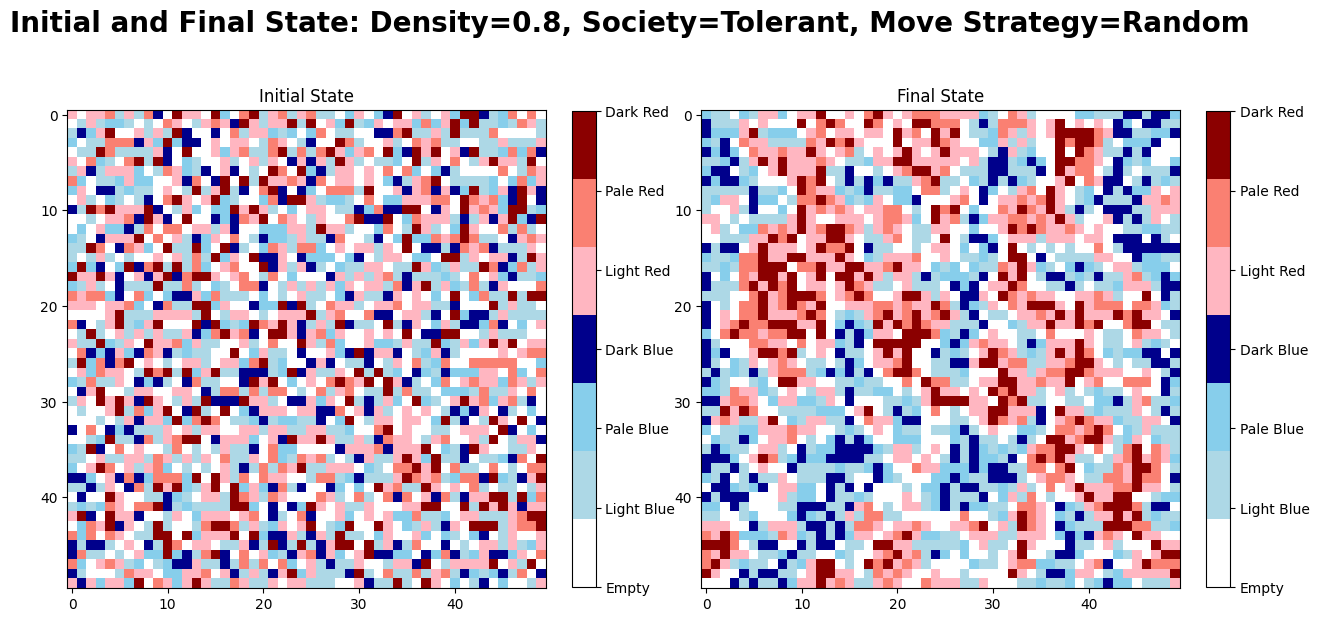

Running configuration: Density=0.8, Society=Tolerant, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


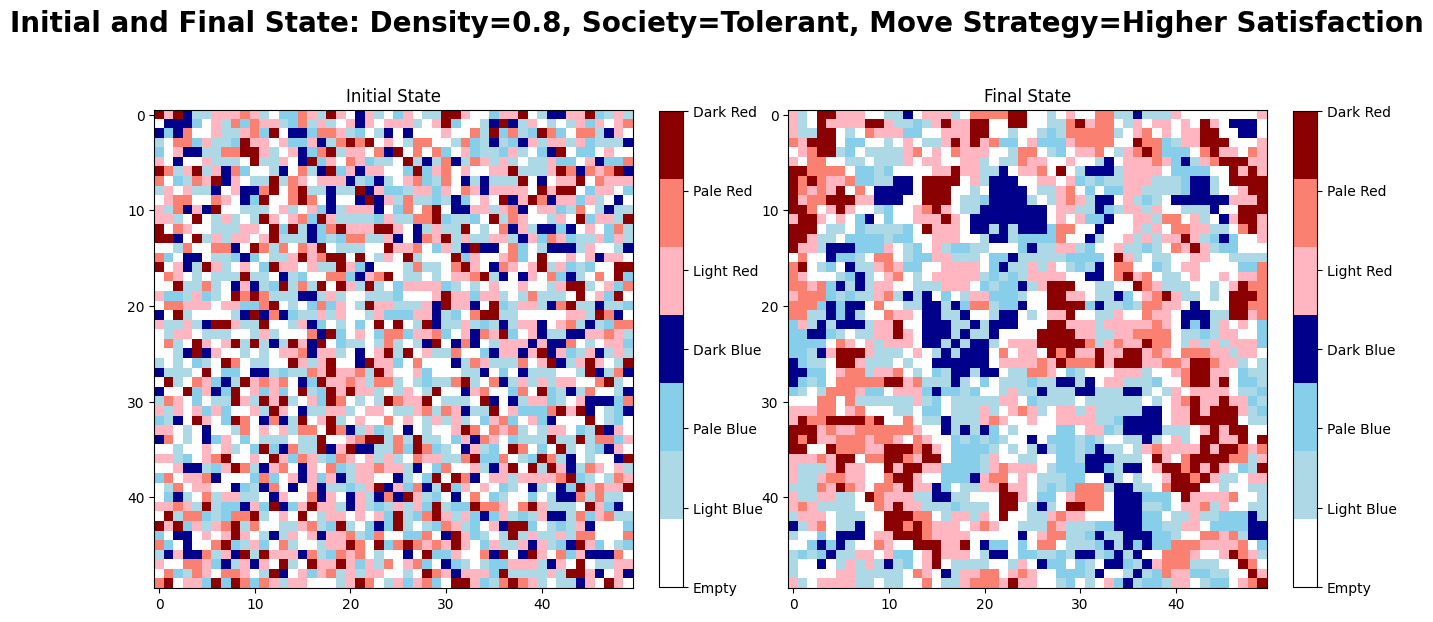

Running configuration: Density=0.8, Society=Tolerant, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


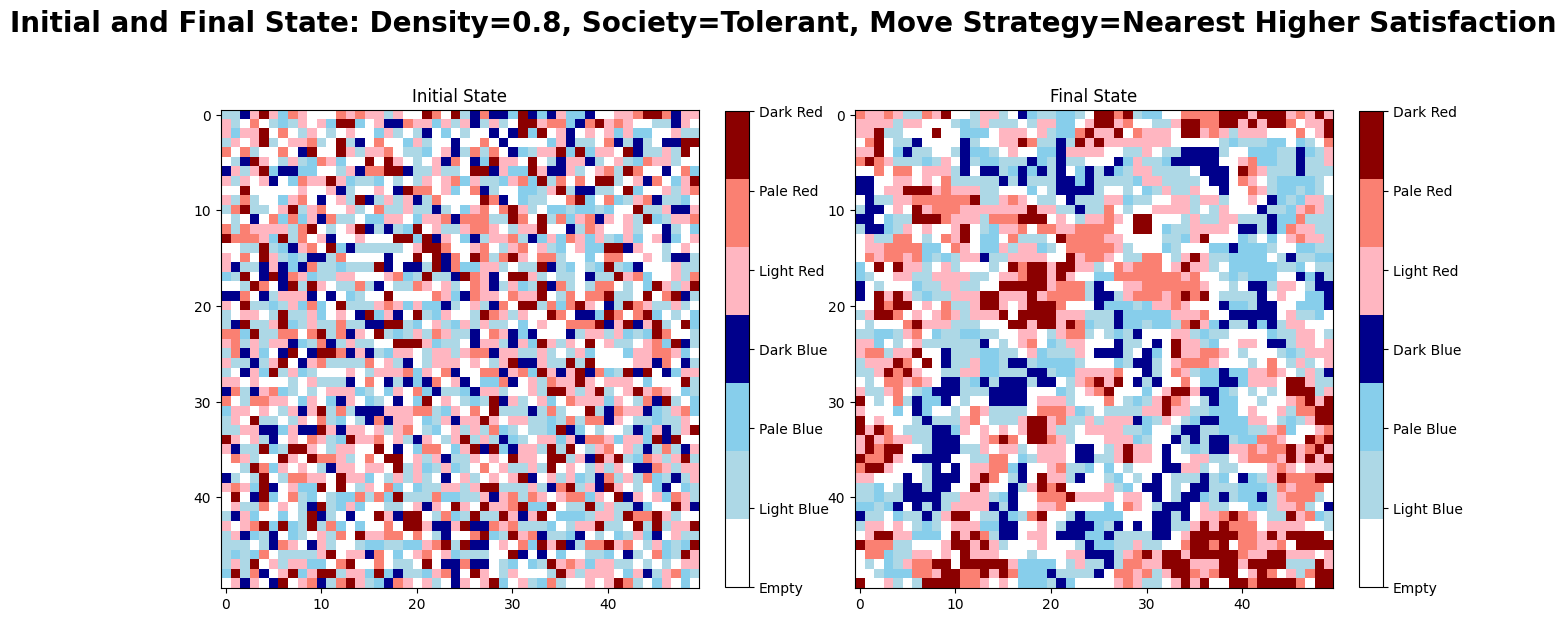

Running configuration: Density=0.8, Society=Neutral, Move Strategy=Random
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


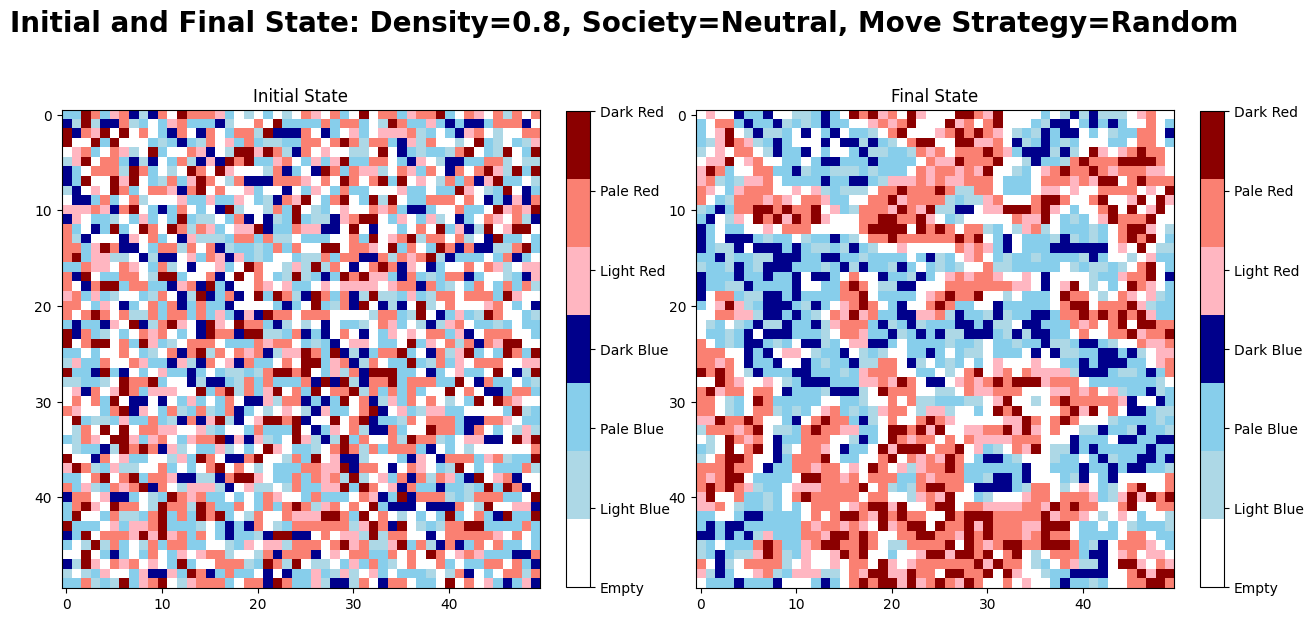

Running configuration: Density=0.8, Society=Neutral, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


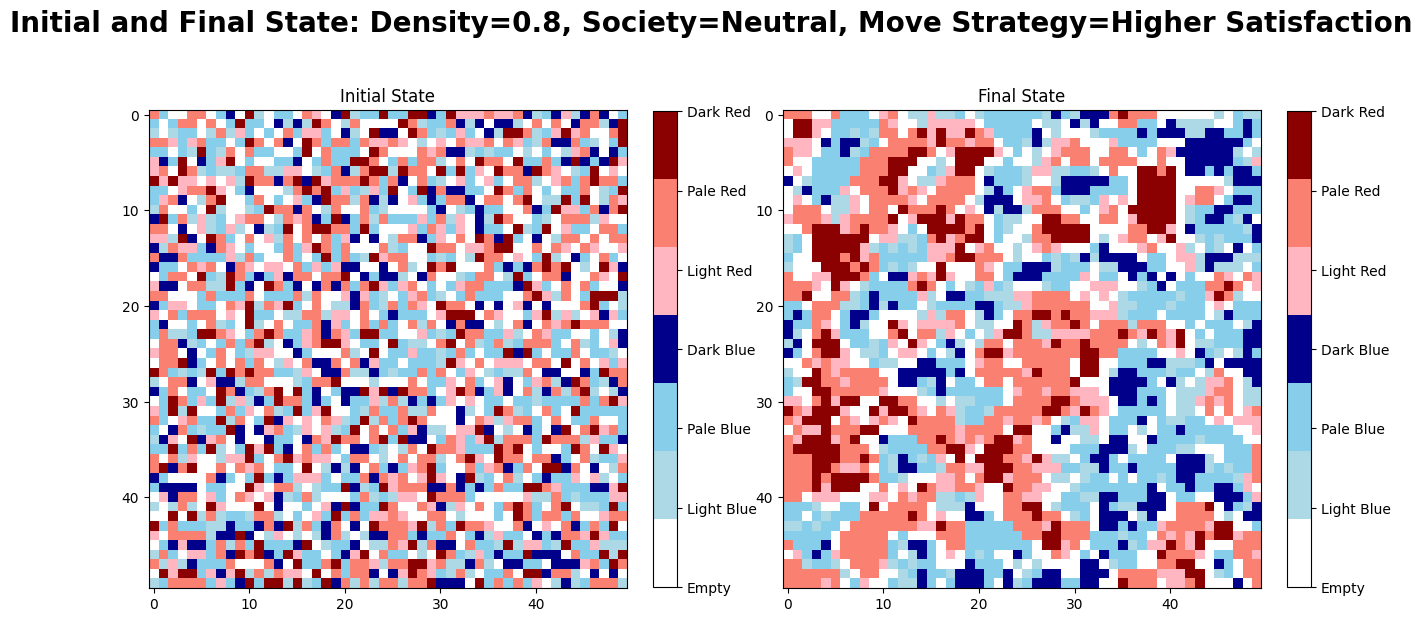

Running configuration: Density=0.8, Society=Neutral, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


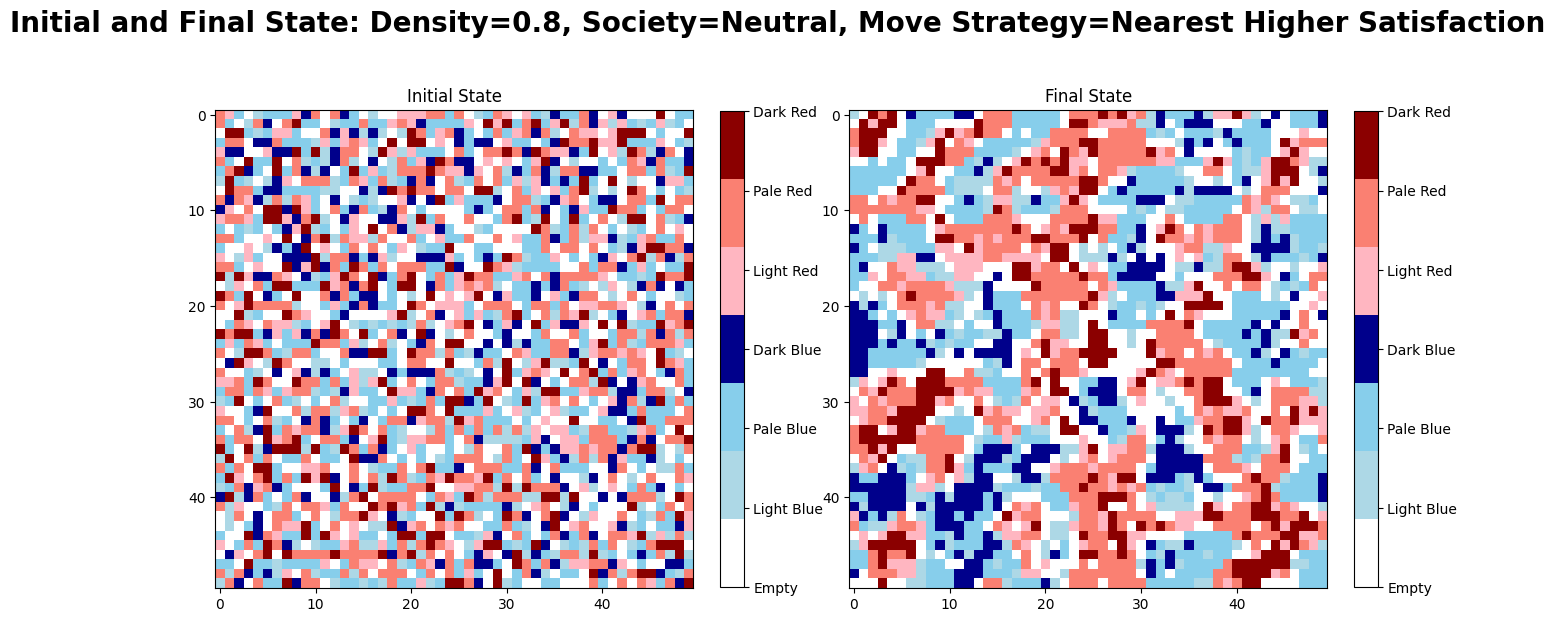

Running configuration: Density=0.8, Society=Intolerant, Move Strategy=Random
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


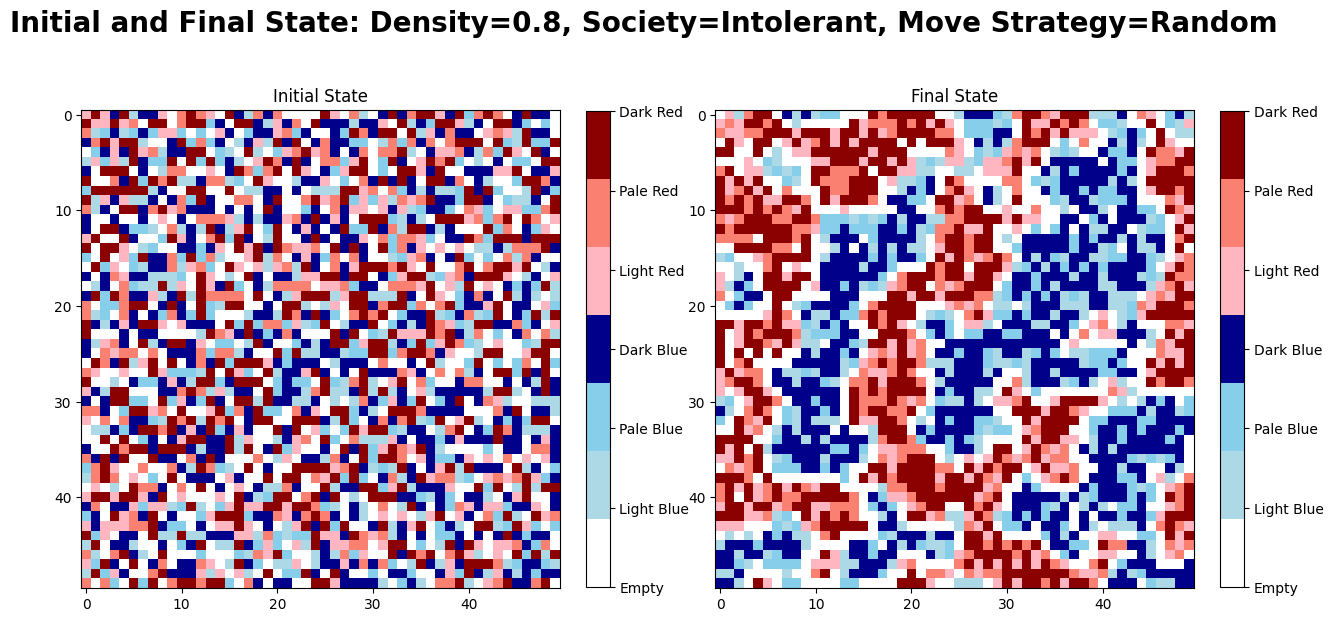

Running configuration: Density=0.8, Society=Intolerant, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


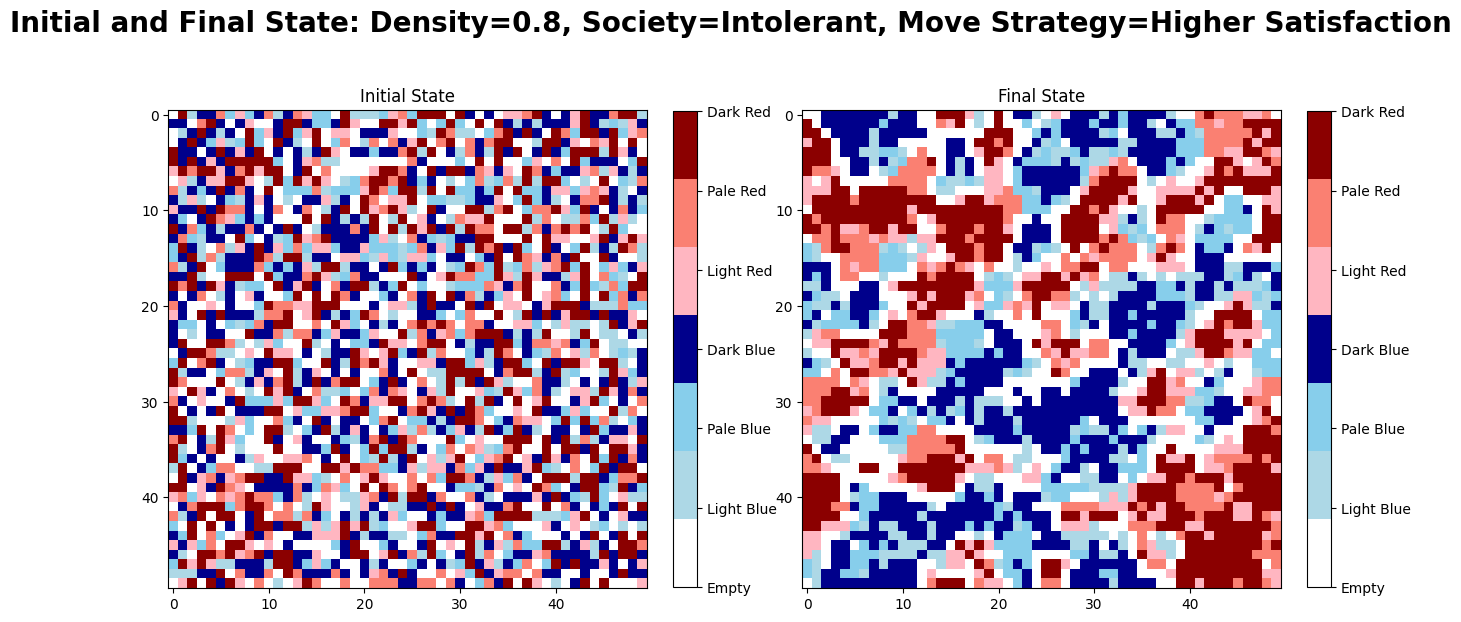

Running configuration: Density=0.8, Society=Intolerant, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


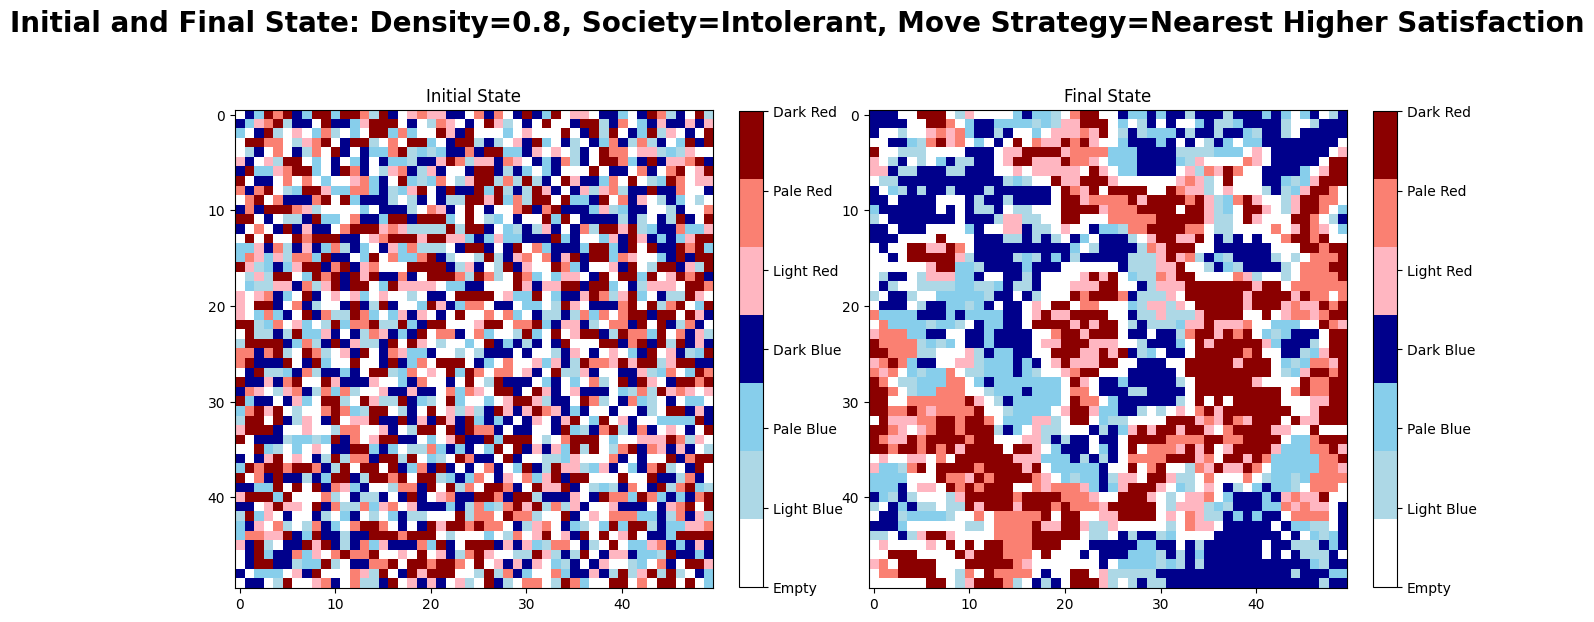

Running configuration: Density=0.5, Society=Tolerant, Move Strategy=Random
  Run 1...
  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: 

  Run 3...
  Run 4...
  Run 5...


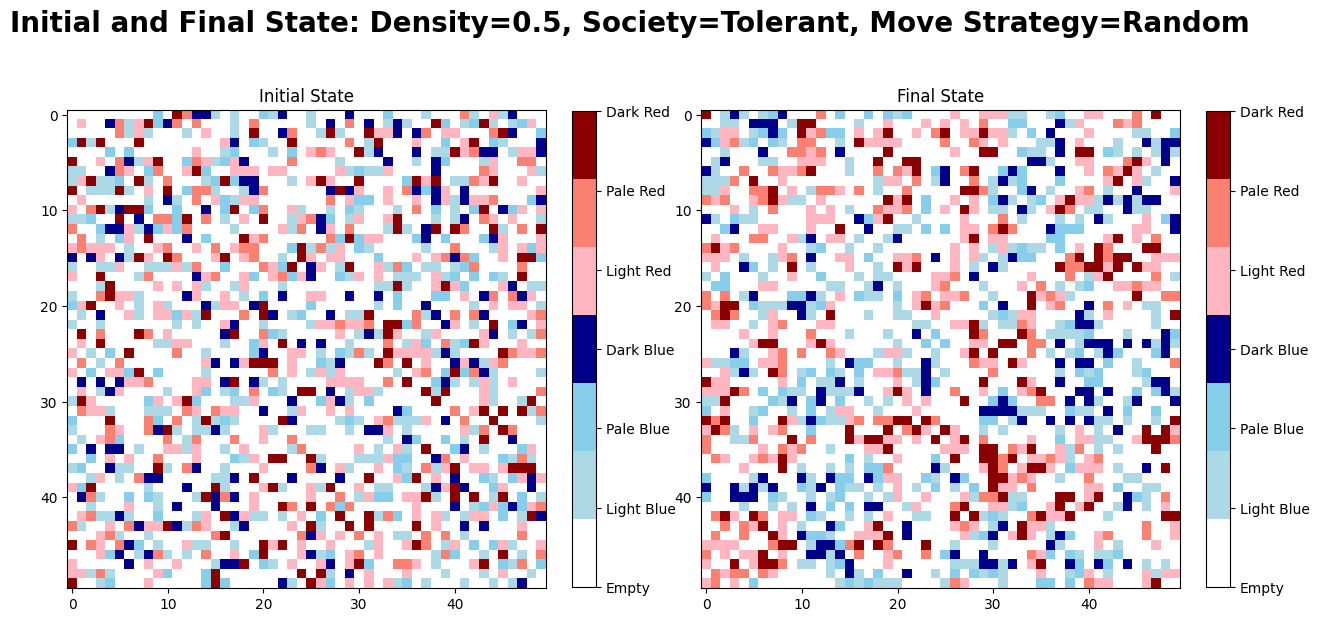

Running configuration: Density=0.5, Society=Tolerant, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


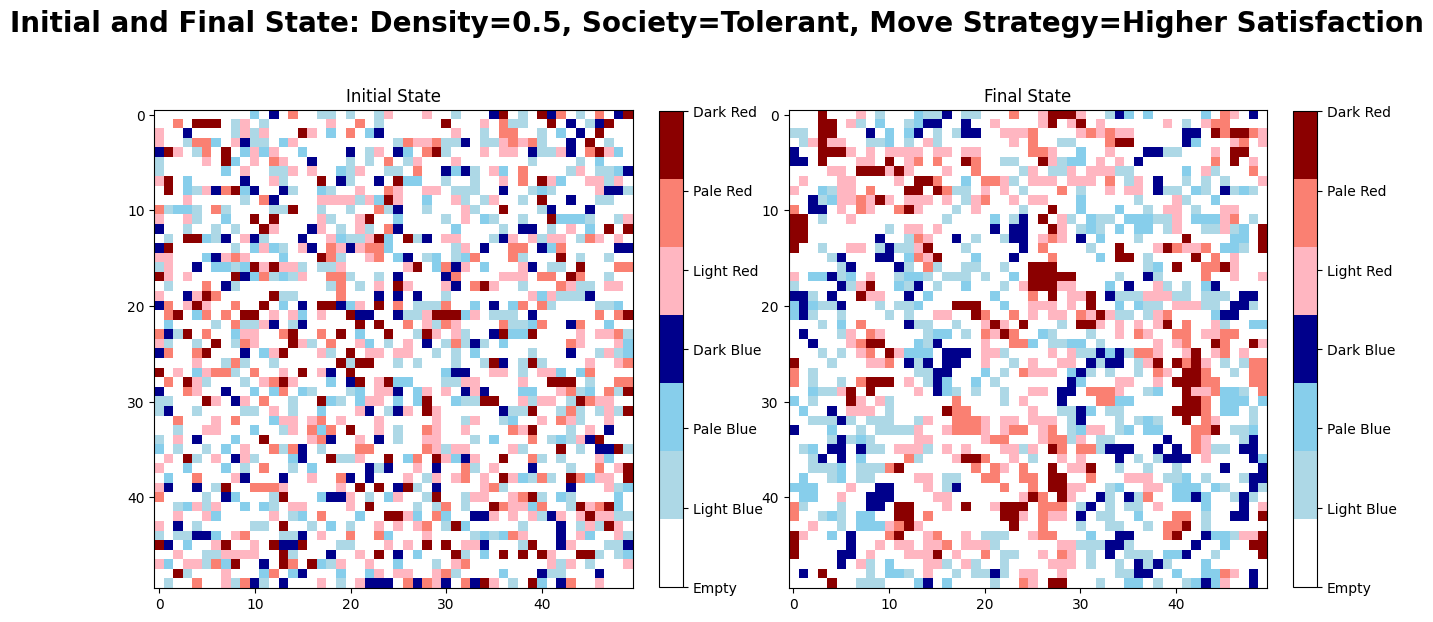

Running configuration: Density=0.5, Society=Tolerant, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


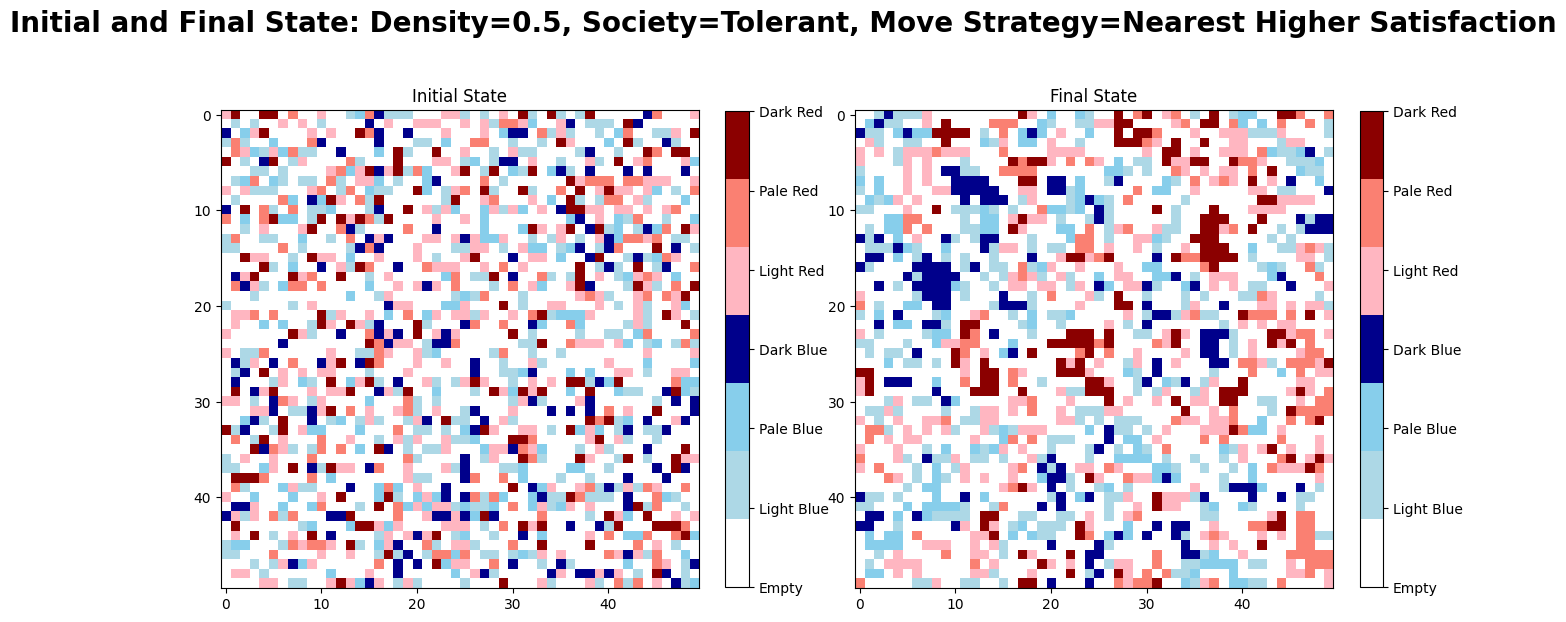

Running configuration: Density=0.5, Society=Neutral, Move Strategy=Random
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...
  Run 3...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 4...
  Run 5...


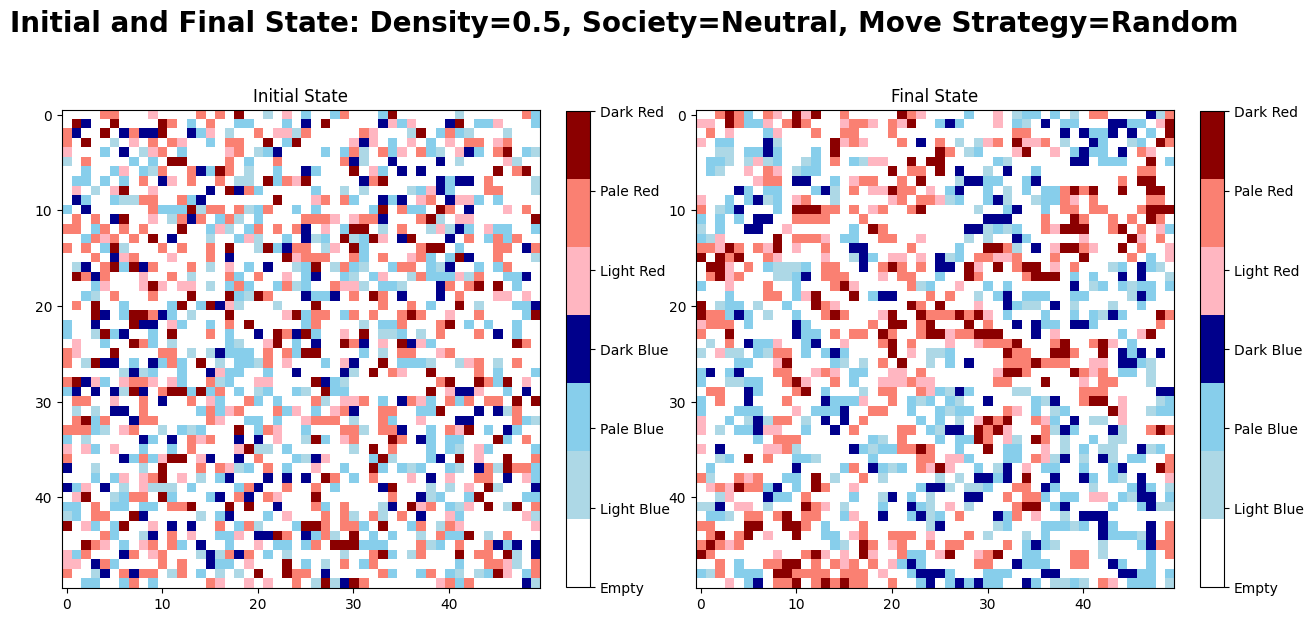

Running configuration: Density=0.5, Society=Neutral, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


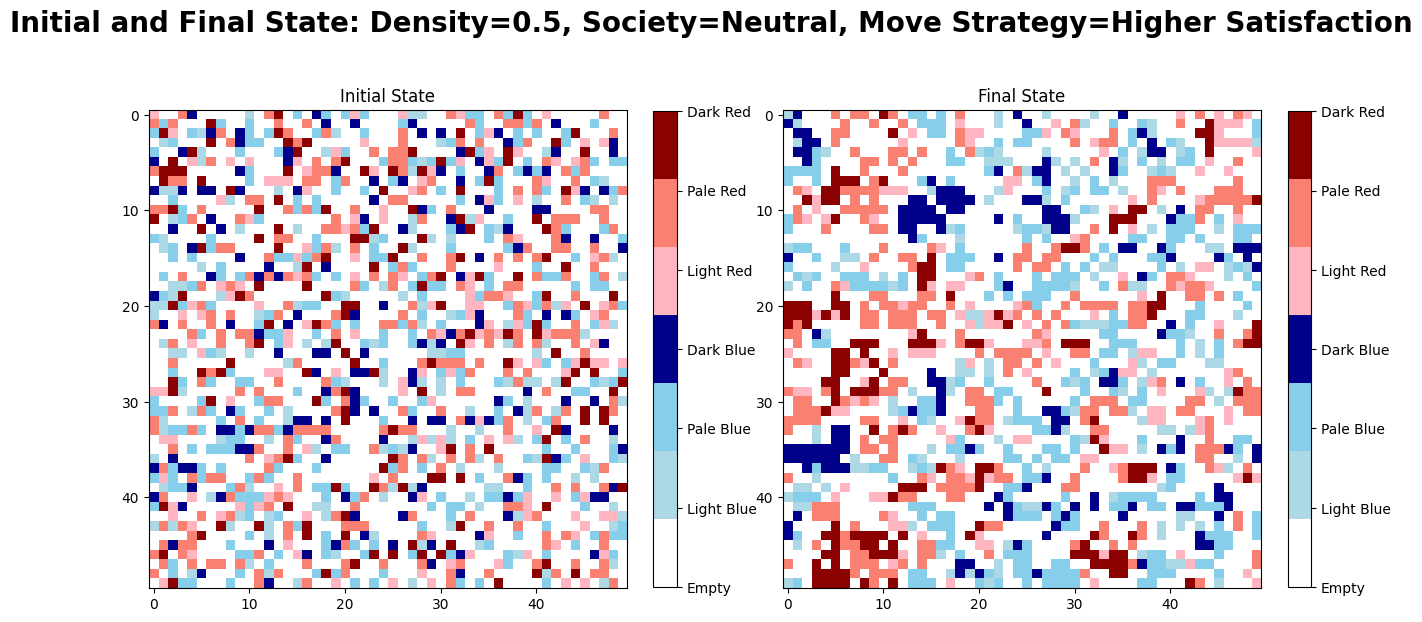

Running configuration: Density=0.5, Society=Neutral, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


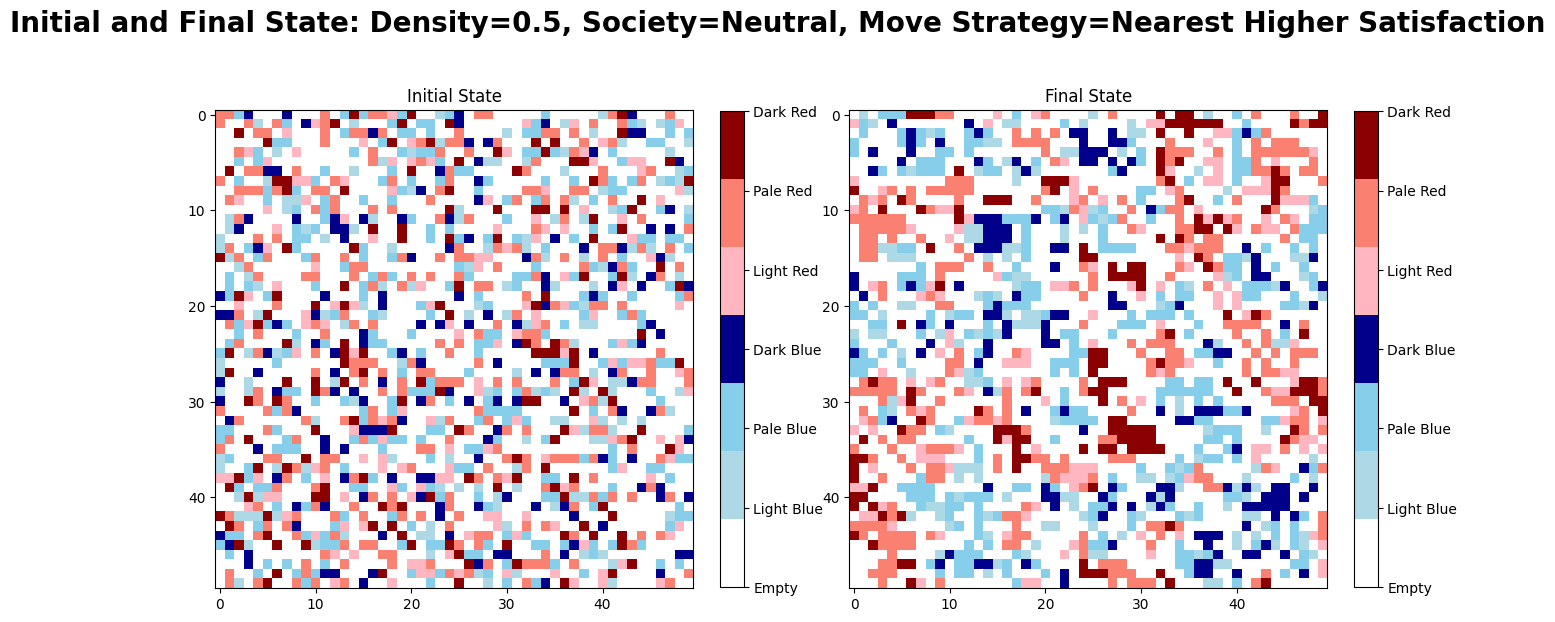

Running configuration: Density=0.5, Society=Intolerant, Move Strategy=Random
  Run 1...
  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: 

  Run 3...
  Run 4...
  Run 5...


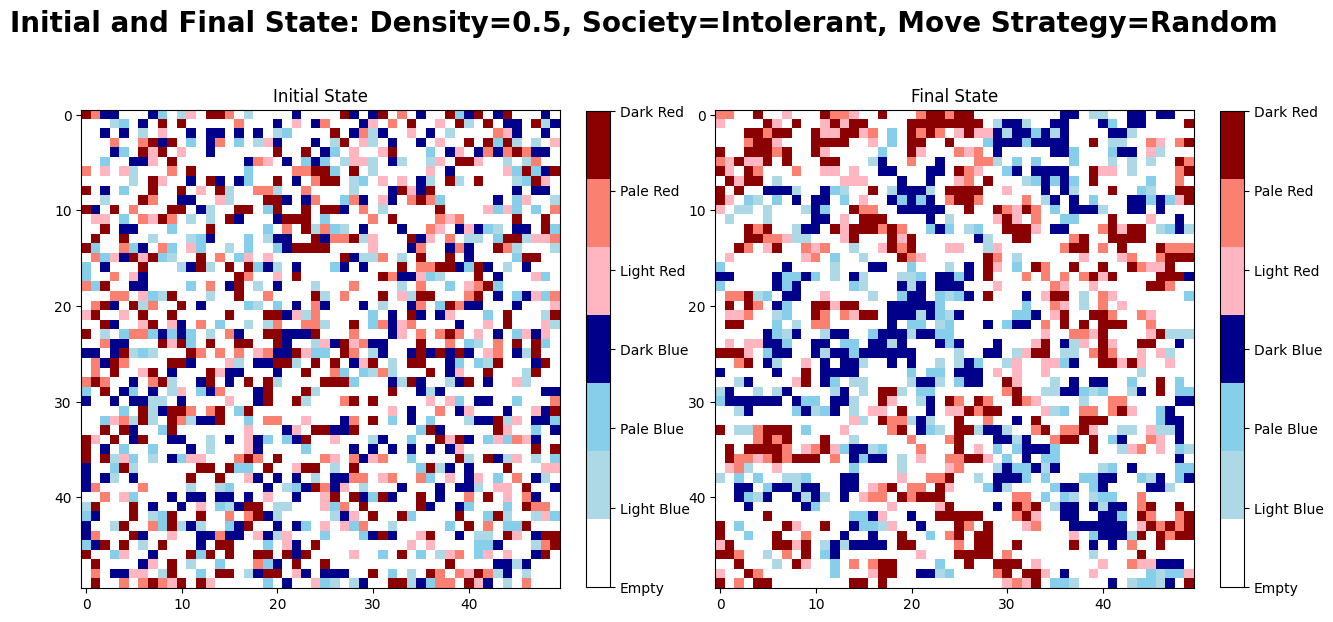

Running configuration: Density=0.5, Society=Intolerant, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


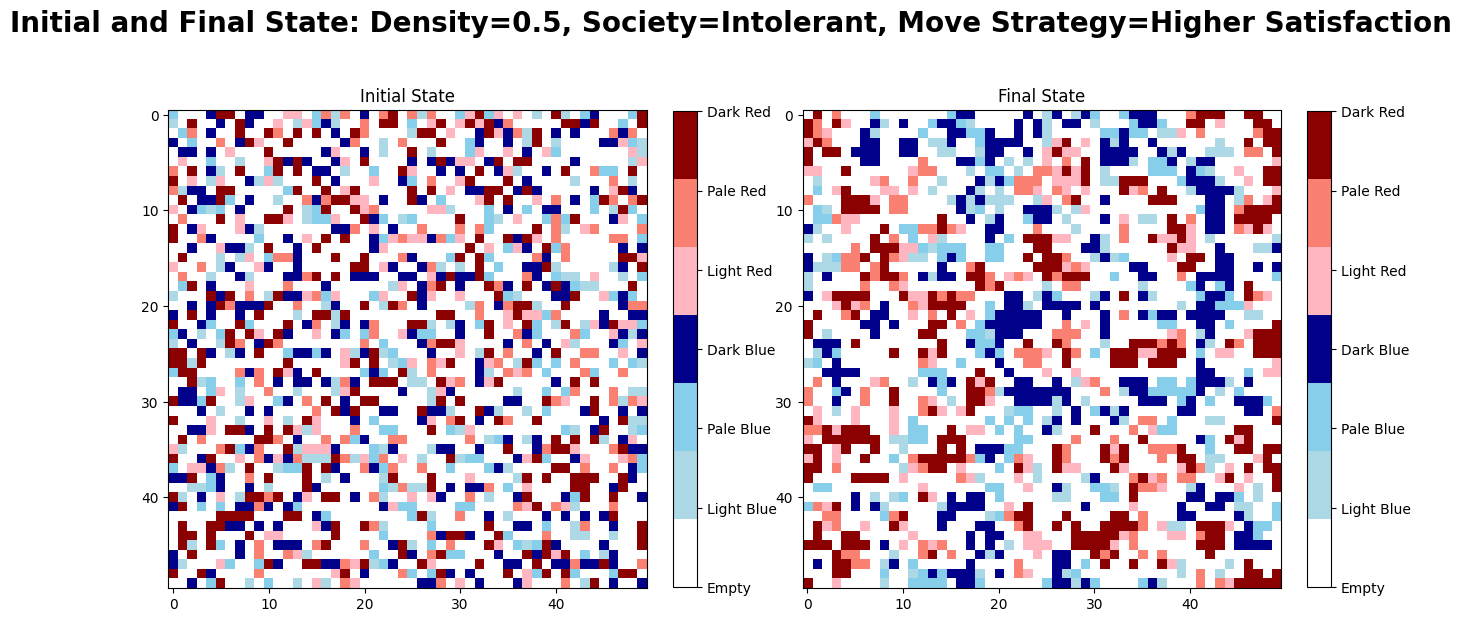

Running configuration: Density=0.5, Society=Intolerant, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


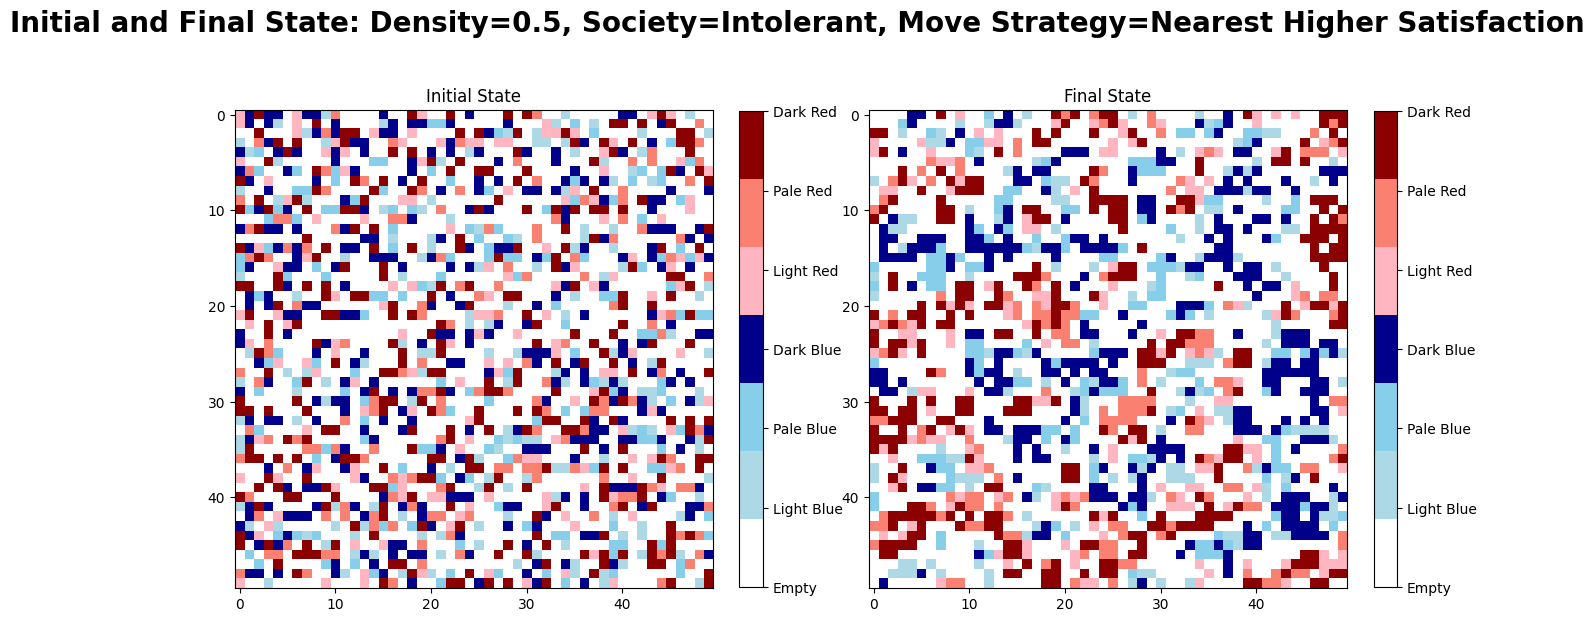

Running configuration: Density=0.2, Society=Tolerant, Move Strategy=Random
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: 

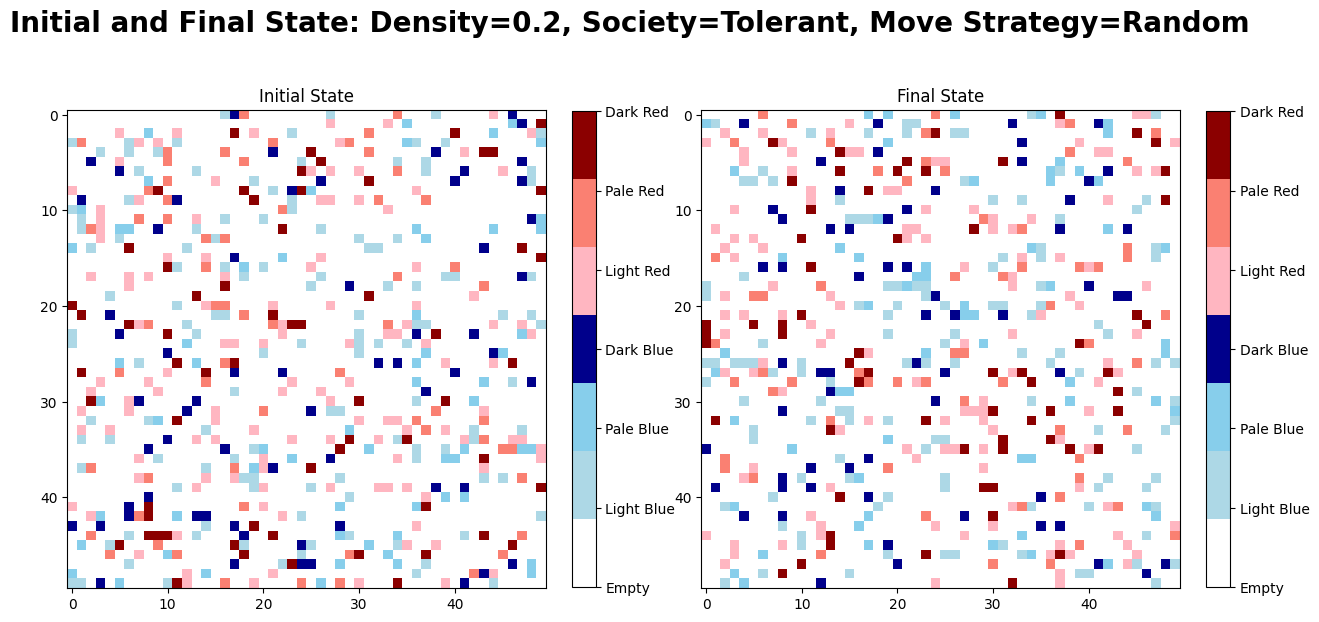

Running configuration: Density=0.2, Society=Tolerant, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


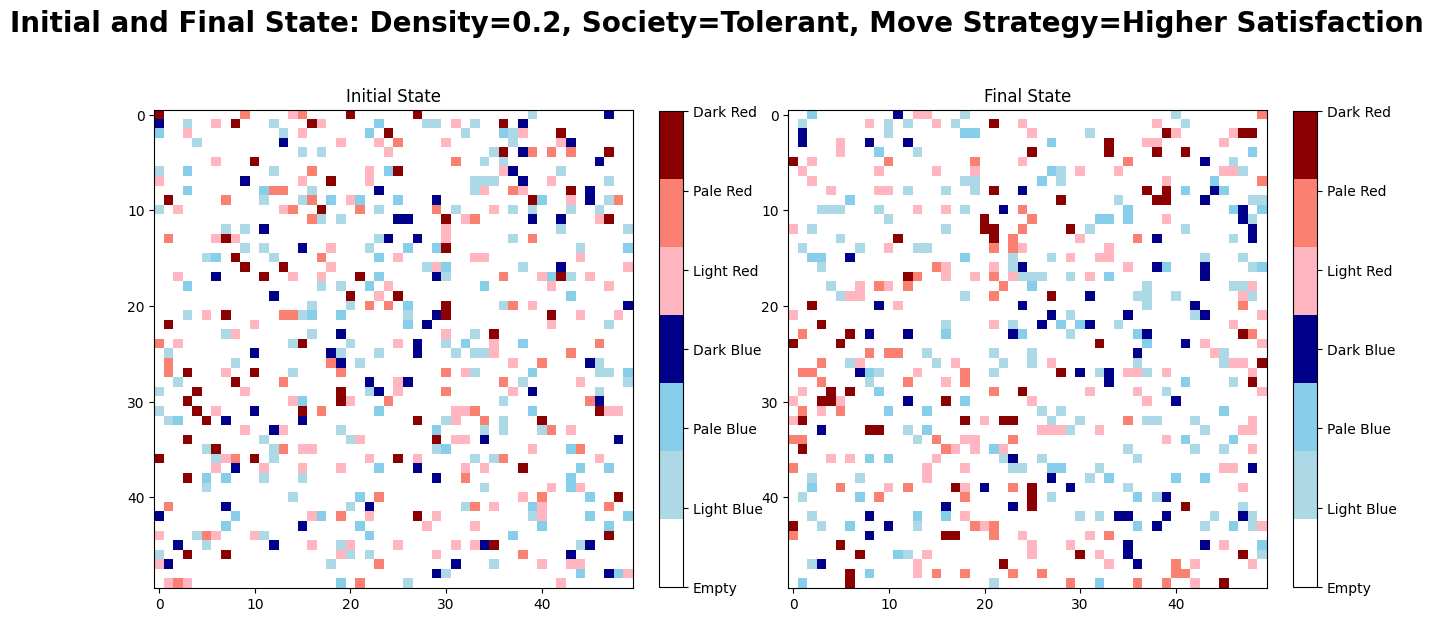

Running configuration: Density=0.2, Society=Tolerant, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


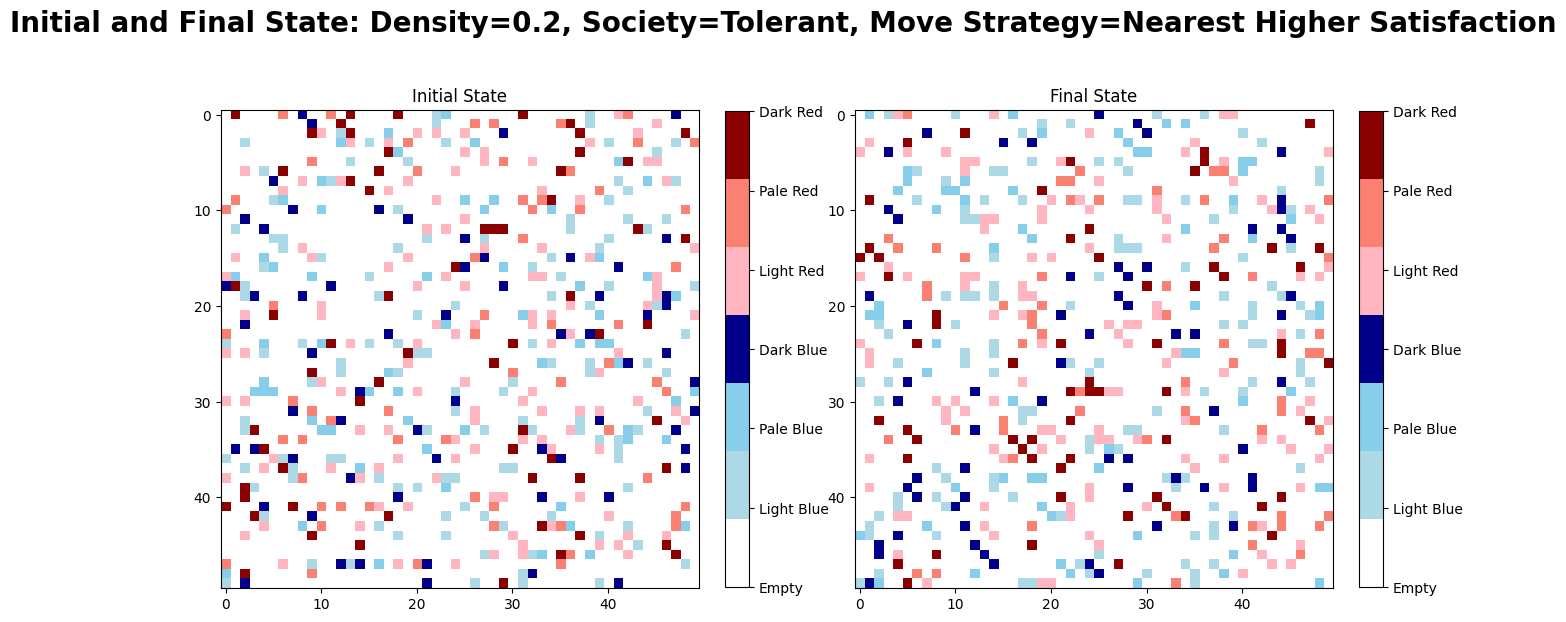

Running configuration: Density=0.2, Society=Neutral, Move Strategy=Random
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: 

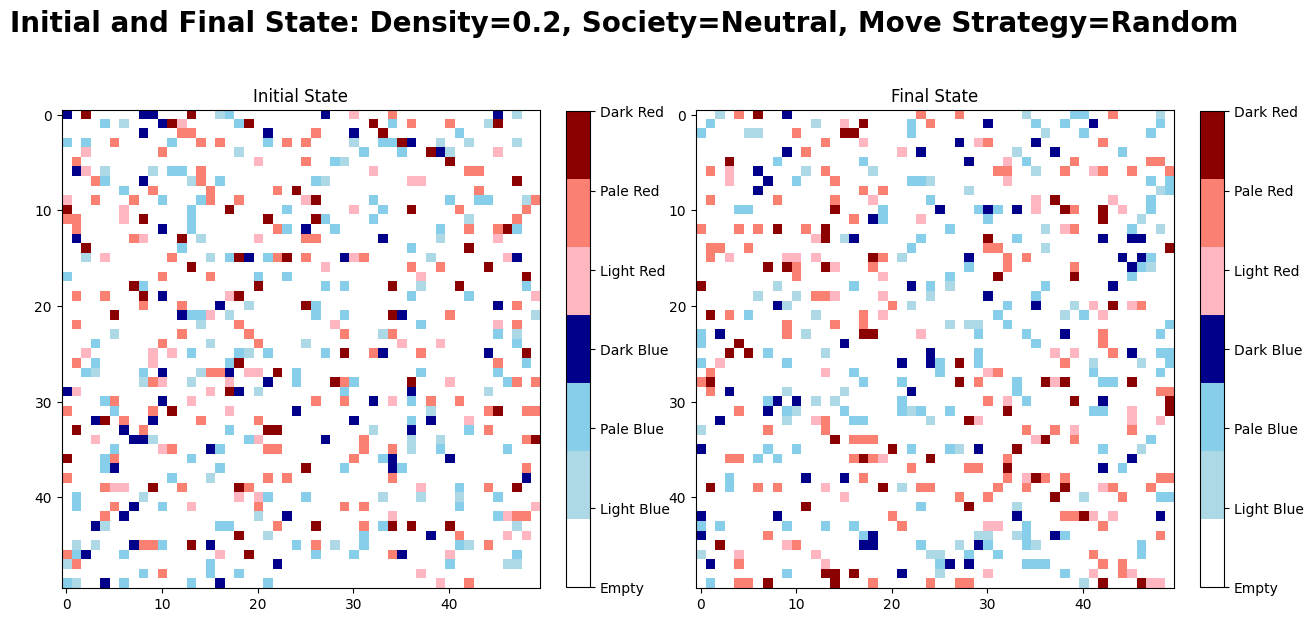

Running configuration: Density=0.2, Society=Neutral, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


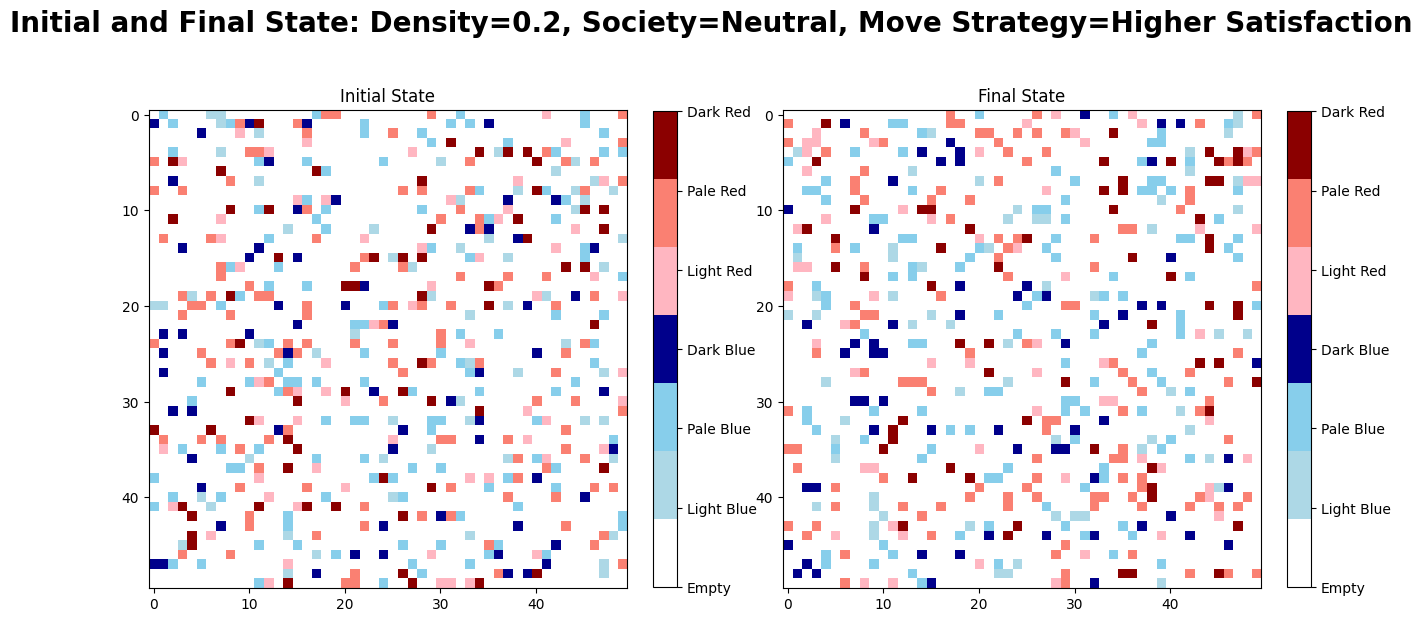

Running configuration: Density=0.2, Society=Neutral, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


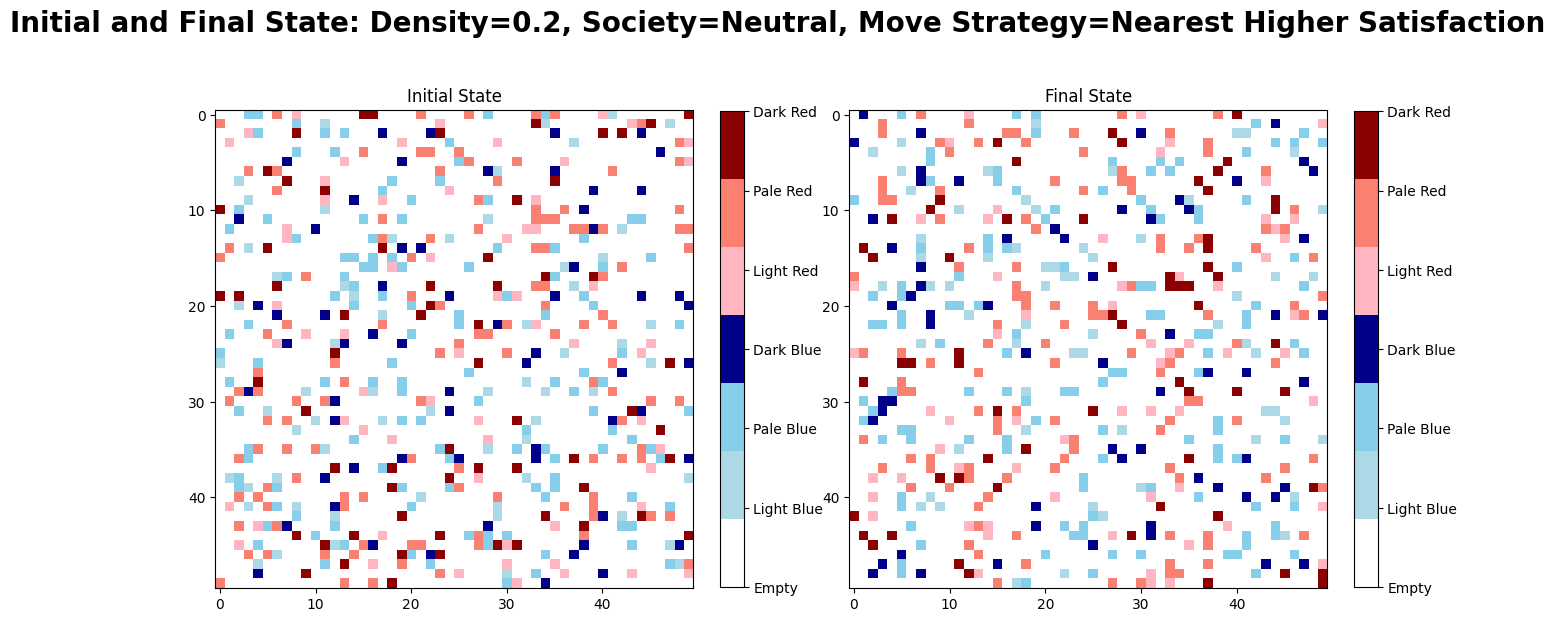

Running configuration: Density=0.2, Society=Intolerant, Move Strategy=Random
  Run 1...
  Run 2...
  Run 3...
  Run 4...
  Run 5...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: 

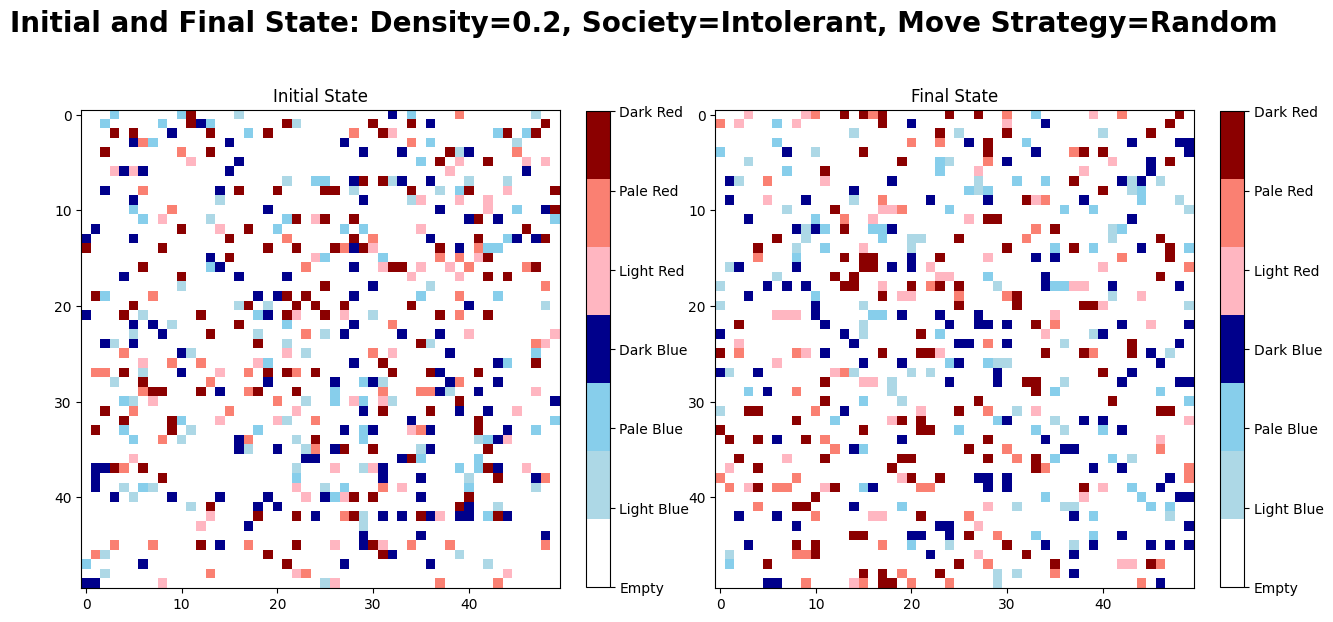

Running configuration: Density=0.2, Society=Intolerant, Move Strategy=Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


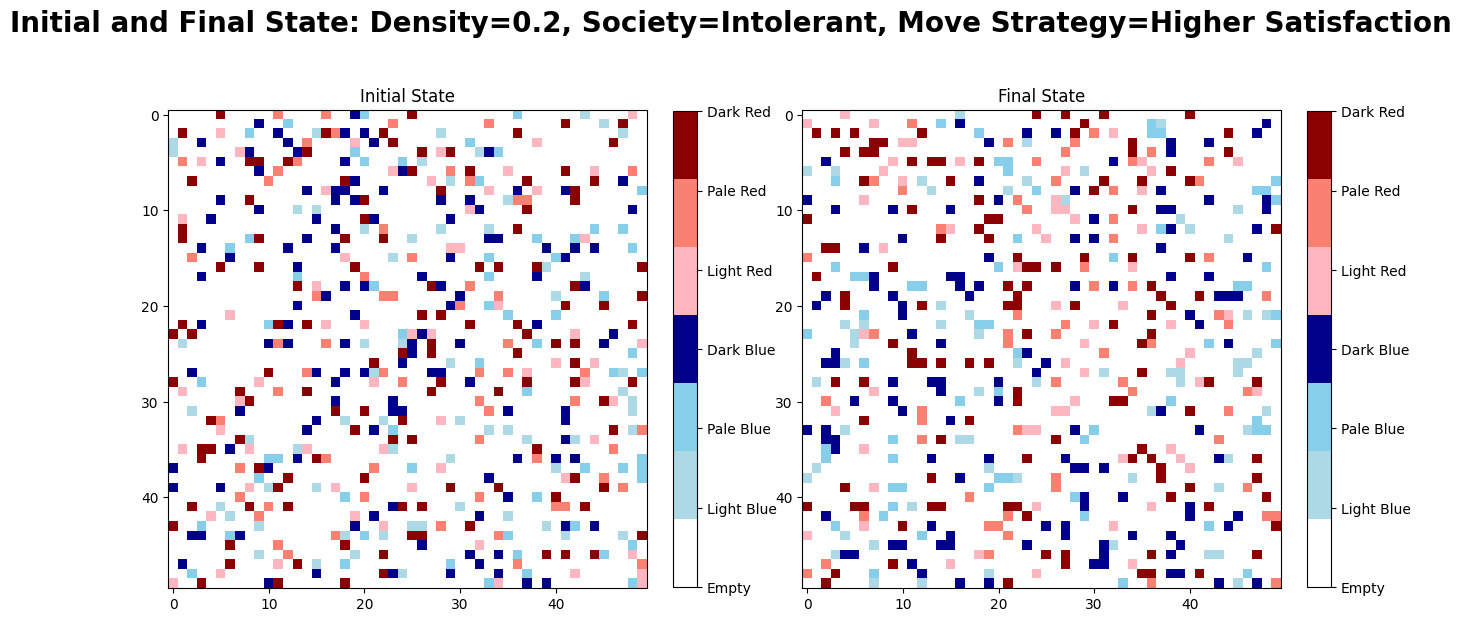

Running configuration: Density=0.2, Society=Intolerant, Move Strategy=Nearest Higher Satisfaction
  Run 1...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 2...


/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)
/usr/local/lib/python3.11/site-packages/mesa/agent.py:82: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


  Run 3...
  Run 4...
  Run 5...


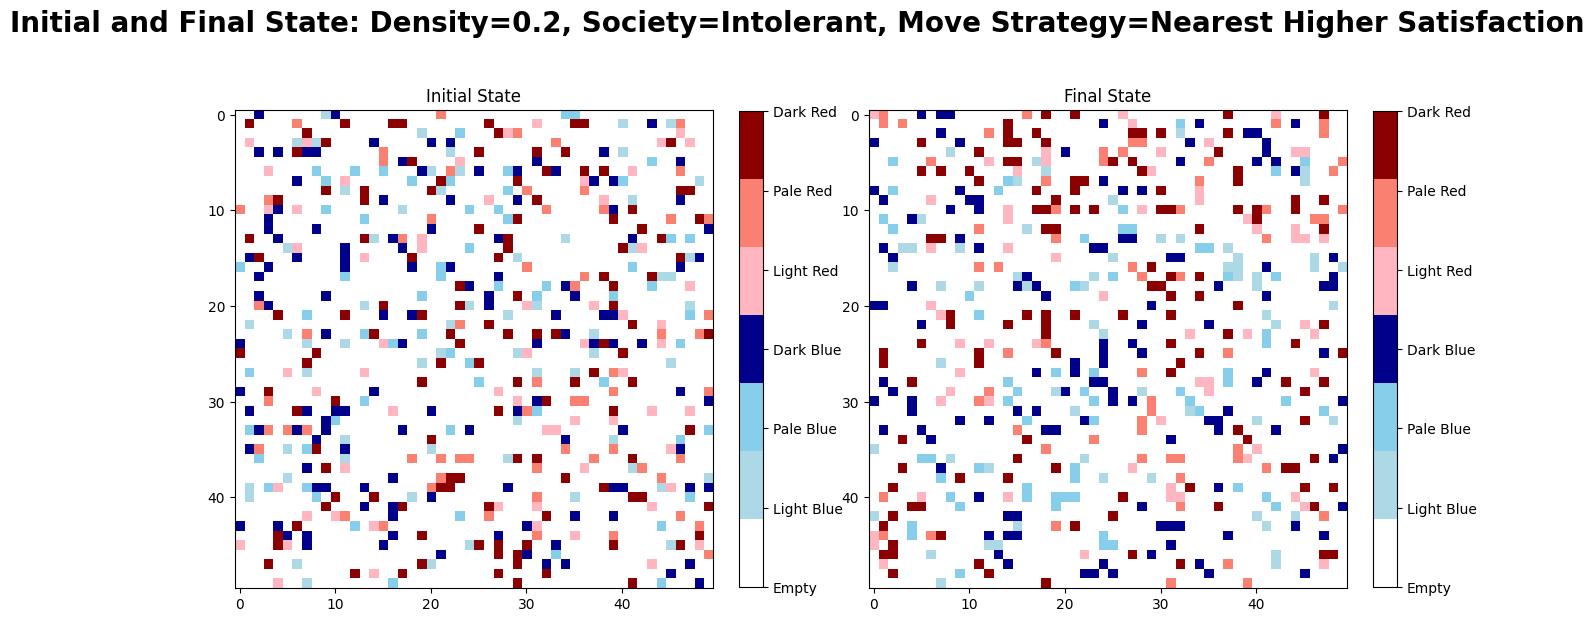

In [5]:
import numpy as np
import matplotlib.pyplot as plt

densities = [.8, .5, .2]
society_types = ["Tolerant", "Neutral", "Intolerant"]
move_strategies = ["Random", "Higher Satisfaction", "Nearest Higher Satisfaction"]

width = 50
height = 50
runs = 5
iterations = 1000

RESULTS = {}

# Define padding function
def padding(data, max_length):
    return data + [data[-1]] * (max_length - len(data))

# Loop through all configurations
for density in densities:
    for society_type in society_types:
        for move_strategy in move_strategies:
            print(f"Running configuration: Density={density}, Society={society_type}, Move Strategy={move_strategy}")
            overall_satisfaction_data = []
            overall_homophily_data = []
            subtype_homophily_data = []
            type_homophily_data = []
            satisfaction_subtypes_data = []
            satisfied_agents_final_data = []
            equilibrium_steps_data = []
            
            
            for run in range(runs):
                print(f"  Run {run + 1}...")
                
                # Initialize the model 
                model = SchellingModel(width, height, density, society_type, move_strategy)
                
                
                if run == 0:
                    initial_grid = model.grid  
                    fig, axes = plt.subplots(1, 2, figsize=(15, 7))  
                    plot_grid_state(initial_grid, "Initial State", axes[0])
                
                
                run_overall_satisfaction = []
                run_overall_homophily = []
                run_subtype_homophily = []
                run_type_homophily = []
                run_satisfaction_subtypes = []
                steps_to_equilibrium = 0
                
                
                for step in range(iterations):
                    
                    satisfaction_avg, _ = model.compute_satisfaction_avg()  # Overall satisfaction
                    overall_homophily = model.compute_overall_homophily()   # Overall homophily
                    red_homophily, blue_homophily, light_homophily, pale_homophily, dark_homophily = model.compute_homophily()
                    satisfaction_subtypes = model.compute_satisfaction_avg_by_subtype()  # Satisfaction for each subtype
                    
                    
                    run_overall_satisfaction.append(satisfaction_avg)
                    run_overall_homophily.append(overall_homophily)
                    run_type_homophily.append([red_homophily, blue_homophily])
                    run_subtype_homophily.append([light_homophily, pale_homophily, dark_homophily])
                    run_satisfaction_subtypes.append(satisfaction_subtypes)
                    
                    
                    model.step()
                    steps_to_equilibrium += 1

                    # Check if equilibrium is reached 
                    if not model.moved:
                        break
                
                
                satisfied_agents_final = sum([1 for agent in model.schedule.agents if agent.satisfaction > 0.4])
                overall_satisfaction_data.append(run_overall_satisfaction)
                overall_homophily_data.append(run_overall_homophily)
                subtype_homophily_data.append(run_subtype_homophily)
                type_homophily_data.append(run_type_homophily)
                satisfaction_subtypes_data.append(run_satisfaction_subtypes)
                satisfied_agents_final_data.append(satisfied_agents_final)
                equilibrium_steps_data.append(steps_to_equilibrium)
                
            
            final_grid = model.grid
            plot_grid_state(final_grid, "Final State", axes[1])
            plt.suptitle(f"Initial and Final State: Density={density}, Society={society_type}, Move Strategy={move_strategy}", fontsize=20, weight='bold')
            plt.show()

            # Compute average results 
            max_steps = max(len(run) for run in overall_satisfaction_data)
            
            
            for i in range(len(overall_satisfaction_data)):
                if len(overall_satisfaction_data[i]) < max_steps:
                    overall_satisfaction_data[i] = padding(overall_satisfaction_data[i], max_steps)
                if len(overall_homophily_data[i]) < max_steps:
                    overall_homophily_data[i] = padding(overall_homophily_data[i], max_steps)
                if len(type_homophily_data[i]) < max_steps:
                    type_homophily_data[i] = padding(type_homophily_data[i], max_steps)
                if len(subtype_homophily_data[i]) < max_steps:
                    subtype_homophily_data[i] = padding(subtype_homophily_data[i], max_steps)
                if len(satisfaction_subtypes_data[i]) < max_steps:
                    satisfaction_subtypes_data[i] = padding(satisfaction_subtypes_data[i], max_steps)
            
            # averaged results for all runs
            RESULTS[(density, society_type, move_strategy)] = {
                "avg_overall_satisfaction": np.mean(overall_satisfaction_data, axis=0),
                "avg_overall_homophily": np.mean(overall_homophily_data, axis=0),
                "avg_type_homophily": np.mean(type_homophily_data, axis=0),
                "avg_subtype_homophily": np.mean(subtype_homophily_data, axis=0),
                "satisfaction_avg_subtypes": np.mean(satisfaction_subtypes_data, axis=0),
                "avg_satisfied_agents_final": np.mean(satisfied_agents_final_data),
                "avg_equilibrium_steps": np.mean(equilibrium_steps_data),
            }


Plotting Overall Satisfactions

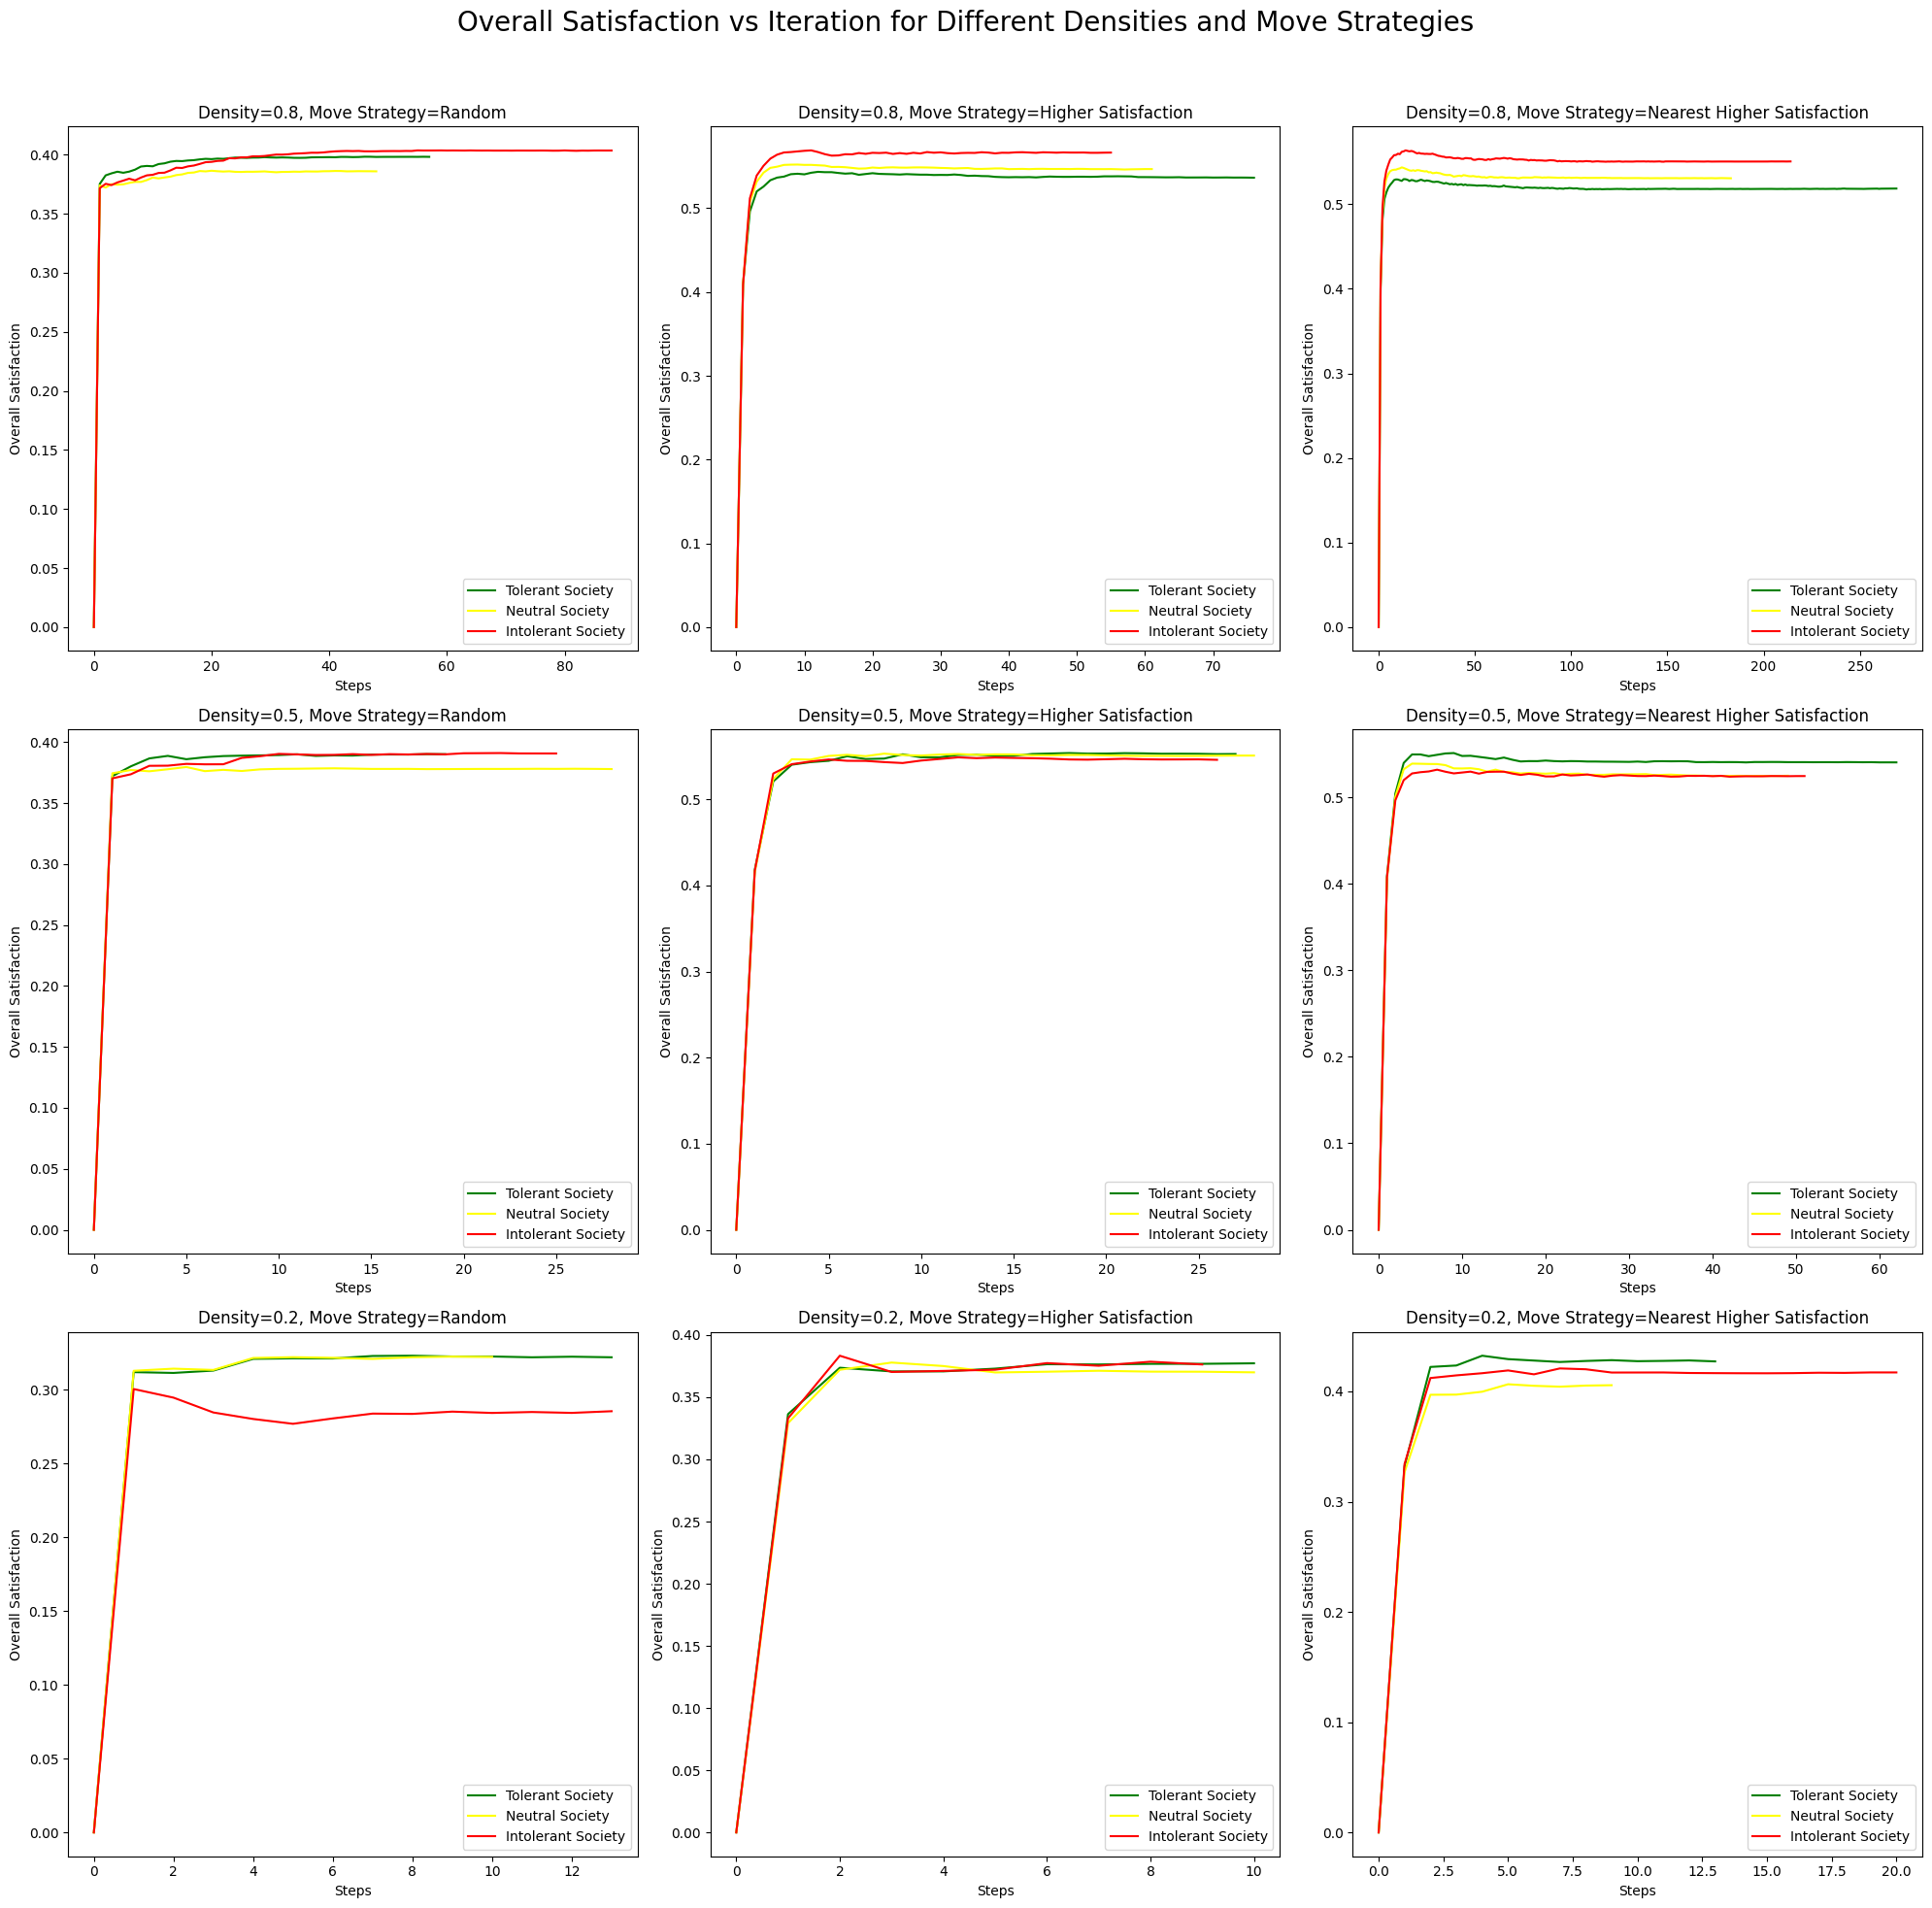

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("Overall Satisfaction vs Iteration for Different Densities and Move Strategies", fontsize=20)


society_colors = {
    "Tolerant": "green",
    "Neutral": "yellow",
    "Intolerant": "red"
}

for i, density in enumerate(densities):
    for j, move_strategy in enumerate(move_strategies):
        
        ax = axes[i, j]
        for society_type in society_types:
            key = (density, society_type, move_strategy)
            
            if key in RESULTS:
                satisfaction_avg = RESULTS[key]["avg_overall_satisfaction"]
                ax.plot(satisfaction_avg, label=f"{society_type} Society", color=society_colors[society_type])
        
        ax.set_title(f"Density={density}, Move Strategy={move_strategy}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Overall Satisfaction")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
for society_type in society_types:
    table_data = []

   
    for density in densities:
        for move_strategy in move_strategies:
            
            avg_steps = RESULTS[(density, society_type, move_strategy)]["avg_equilibrium_steps"]
            avg_satisfied_agents = RESULTS[(density, society_type, move_strategy)]["avg_satisfied_agents_final"]
            
            
            table_data.append([density, move_strategy, avg_steps, avg_satisfied_agents])

    
    df = pd.DataFrame(table_data, columns=["Density", "Move Strategy", "Steps to Equilibrium", "Satisfied Agents"])

    
    print(f"Society Type: {society_type}")
    print(df)
    print("\n" + "="*50 + "\n")

Society Type: Tolerant
   Density                Move Strategy  Steps to Equilibrium  \
0      0.8                       Random                  46.0   
1      0.8          Higher Satisfaction                  66.6   
2      0.8  Nearest Higher Satisfaction                 144.2   
3      0.5                       Random                  18.8   
4      0.5          Higher Satisfaction                  21.8   
5      0.5  Nearest Higher Satisfaction                  43.6   
6      0.2                       Random                  10.8   
7      0.2          Higher Satisfaction                   8.2   
8      0.2  Nearest Higher Satisfaction                  10.4   

   Satisfied Agents  
0             903.2  
1            1328.4  
2            1282.0  
3             535.0  
4             804.6  
5             789.8  
6             193.6  
7             220.2  
8             246.2  


Society Type: Neutral
   Density                Move Strategy  Steps to Equilibrium  \
0      0.8       

Subtype Satisfaction

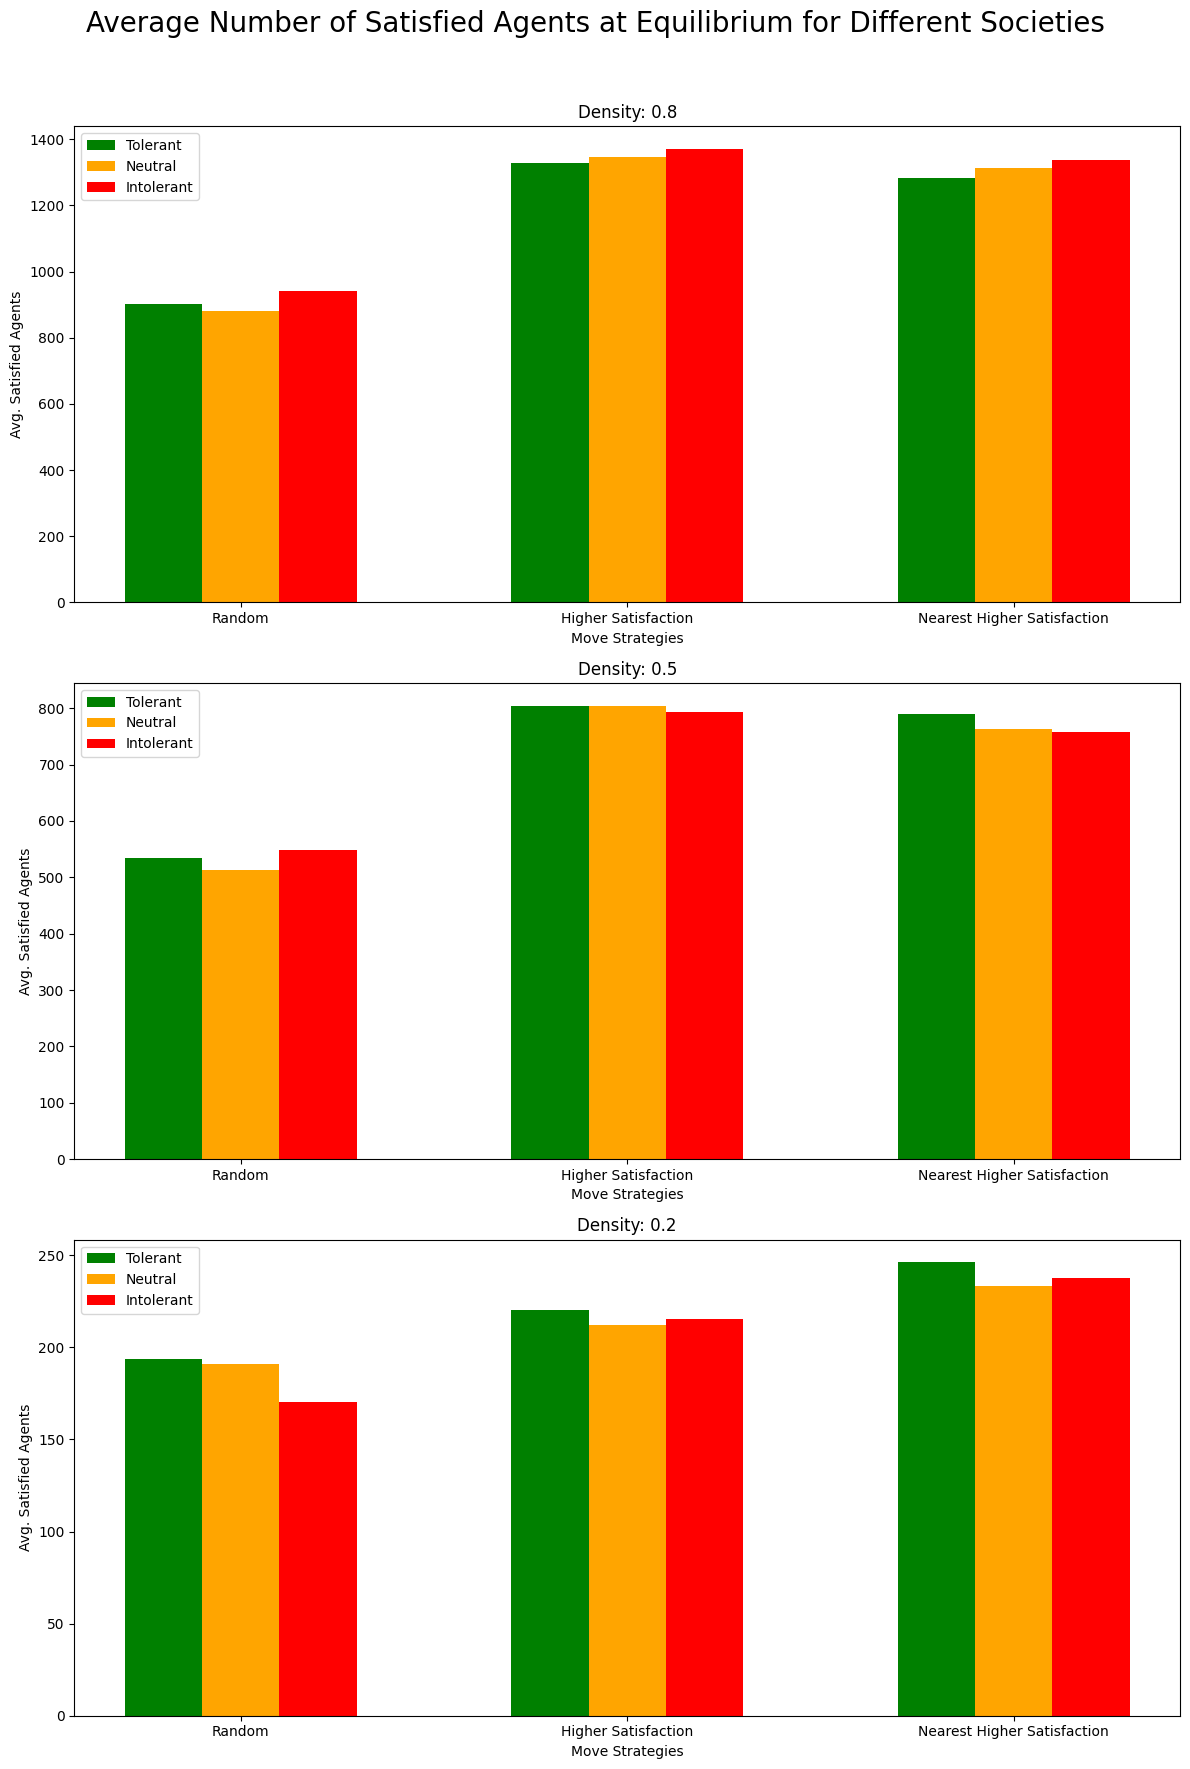

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle("Average Number of Satisfied Agents at Equilibrium for Different Societies", fontsize=20)

bar_width = 0.2
x_positions = np.arange(len(move_strategies))


for i, density in enumerate(densities):
    ax = axs[i]

    
    tolerant_satisfied = [RESULTS[(density, "Tolerant", move_strategy)]["avg_satisfied_agents_final"] for move_strategy in move_strategies]
    neutral_satisfied = [RESULTS[(density, "Neutral", move_strategy)]["avg_satisfied_agents_final"] for move_strategy in move_strategies]
    intolerant_satisfied = [RESULTS[(density, "Intolerant", move_strategy)]["avg_satisfied_agents_final"] for move_strategy in move_strategies]

    
    ax.bar(x_positions - bar_width, tolerant_satisfied, bar_width, label="Tolerant", color='green')
    ax.bar(x_positions, neutral_satisfied, bar_width, label="Neutral", color='orange')
    ax.bar(x_positions + bar_width, intolerant_satisfied, bar_width, label="Intolerant", color='red')

    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(move_strategies)
    ax.set_xlabel("Move Strategies")
    ax.set_ylabel("Avg. Satisfied Agents")

    
    ax.set_title(f"Density: {density}")

    
    ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

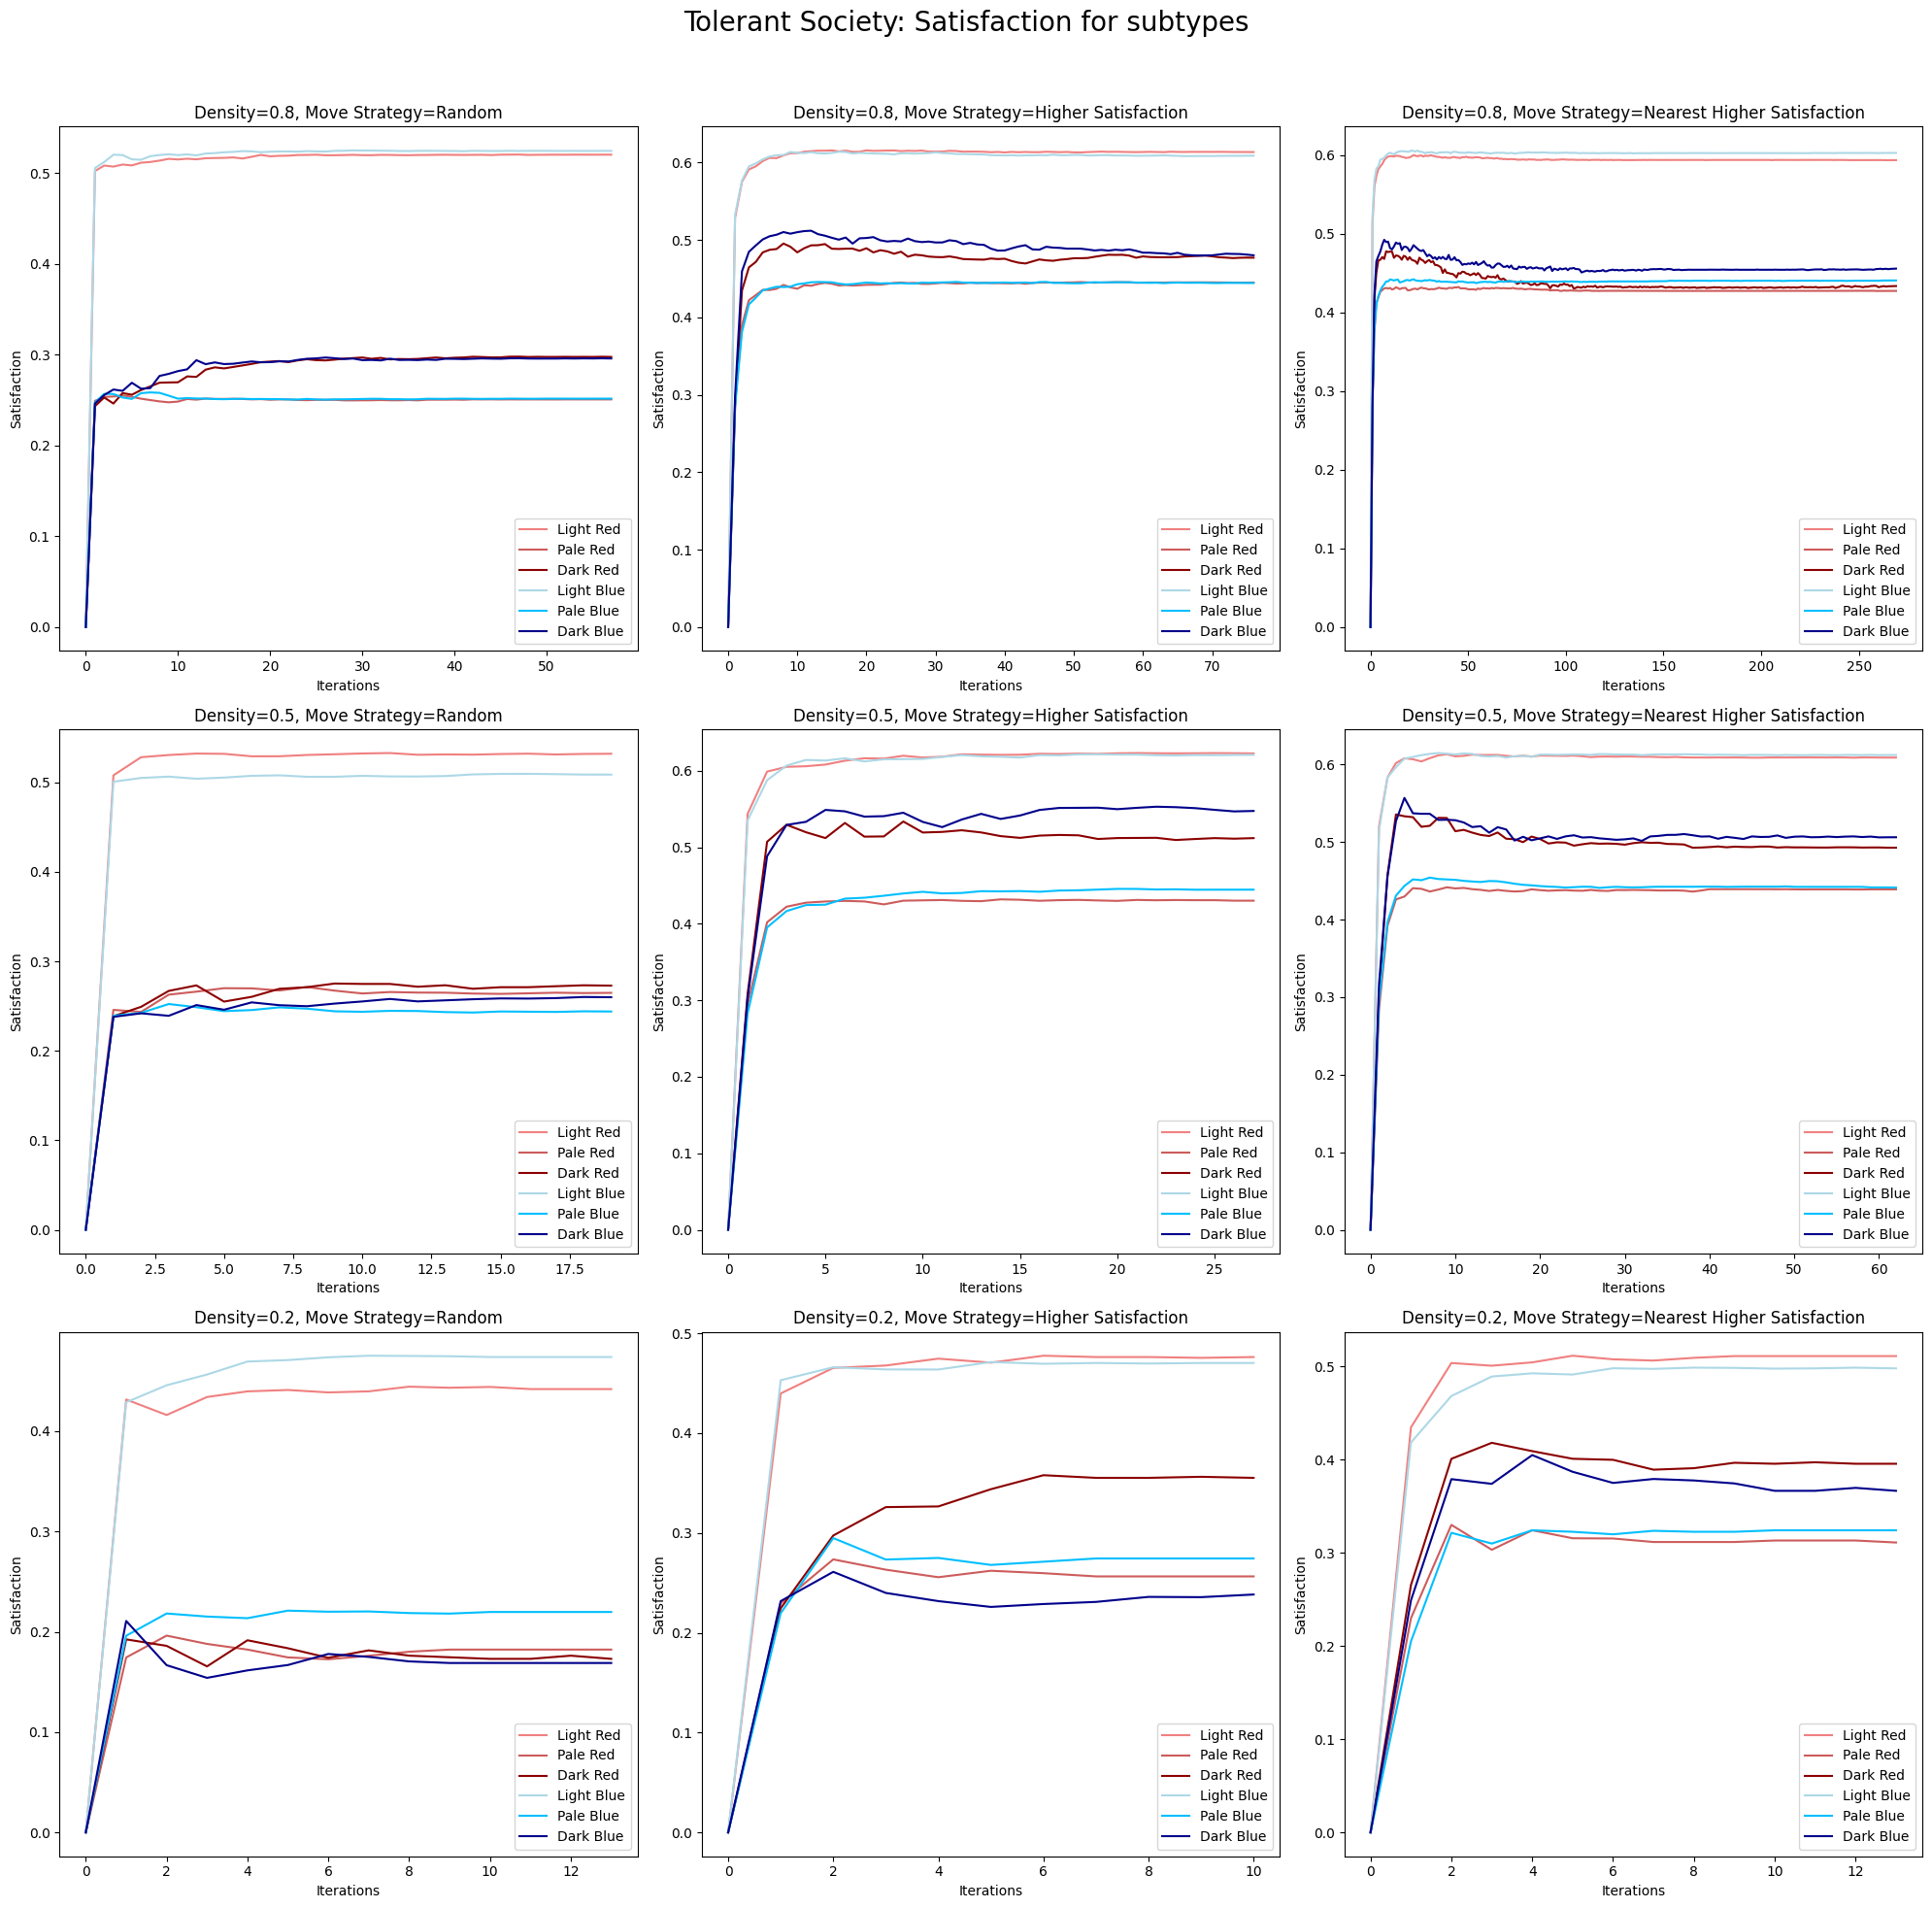

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  
society_type = "Tolerant" 

fig.suptitle(f"{society_type} Society: Satisfaction for subtypes", fontsize=20)

for i, density in enumerate(densities):
    for j, move_strategy in enumerate(move_strategies):
        
        ax = axes[i, j]
        key = (density, society_type, move_strategy)
        
        
        if key in RESULTS:
            
            satisfaction_avg_subtypes = RESULTS[key]["satisfaction_avg_subtypes"]
            
            # Plot satisfaction for each subtype assuming the order: [Light Red, Pale Red, Dark Red, Light Blue, Pale Blue, Dark Blue]
            ax.plot(satisfaction_avg_subtypes[:, 0], label="Light Red", color='lightcoral')
            ax.plot(satisfaction_avg_subtypes[:, 1], label="Pale Red", color='indianred')
            ax.plot(satisfaction_avg_subtypes[:, 2], label="Dark Red", color='darkred')
            ax.plot(satisfaction_avg_subtypes[:, 3], label="Light Blue", color='lightblue')
            ax.plot(satisfaction_avg_subtypes[:, 4], label="Pale Blue", color='deepskyblue')
            ax.plot(satisfaction_avg_subtypes[:, 5], label="Dark Blue", color='darkblue')
        else:
            print(f"Warning: Key {key} not found in RESULTS")

        ax.set_title(f"Density={density}, Move Strategy={move_strategy}")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Satisfaction")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


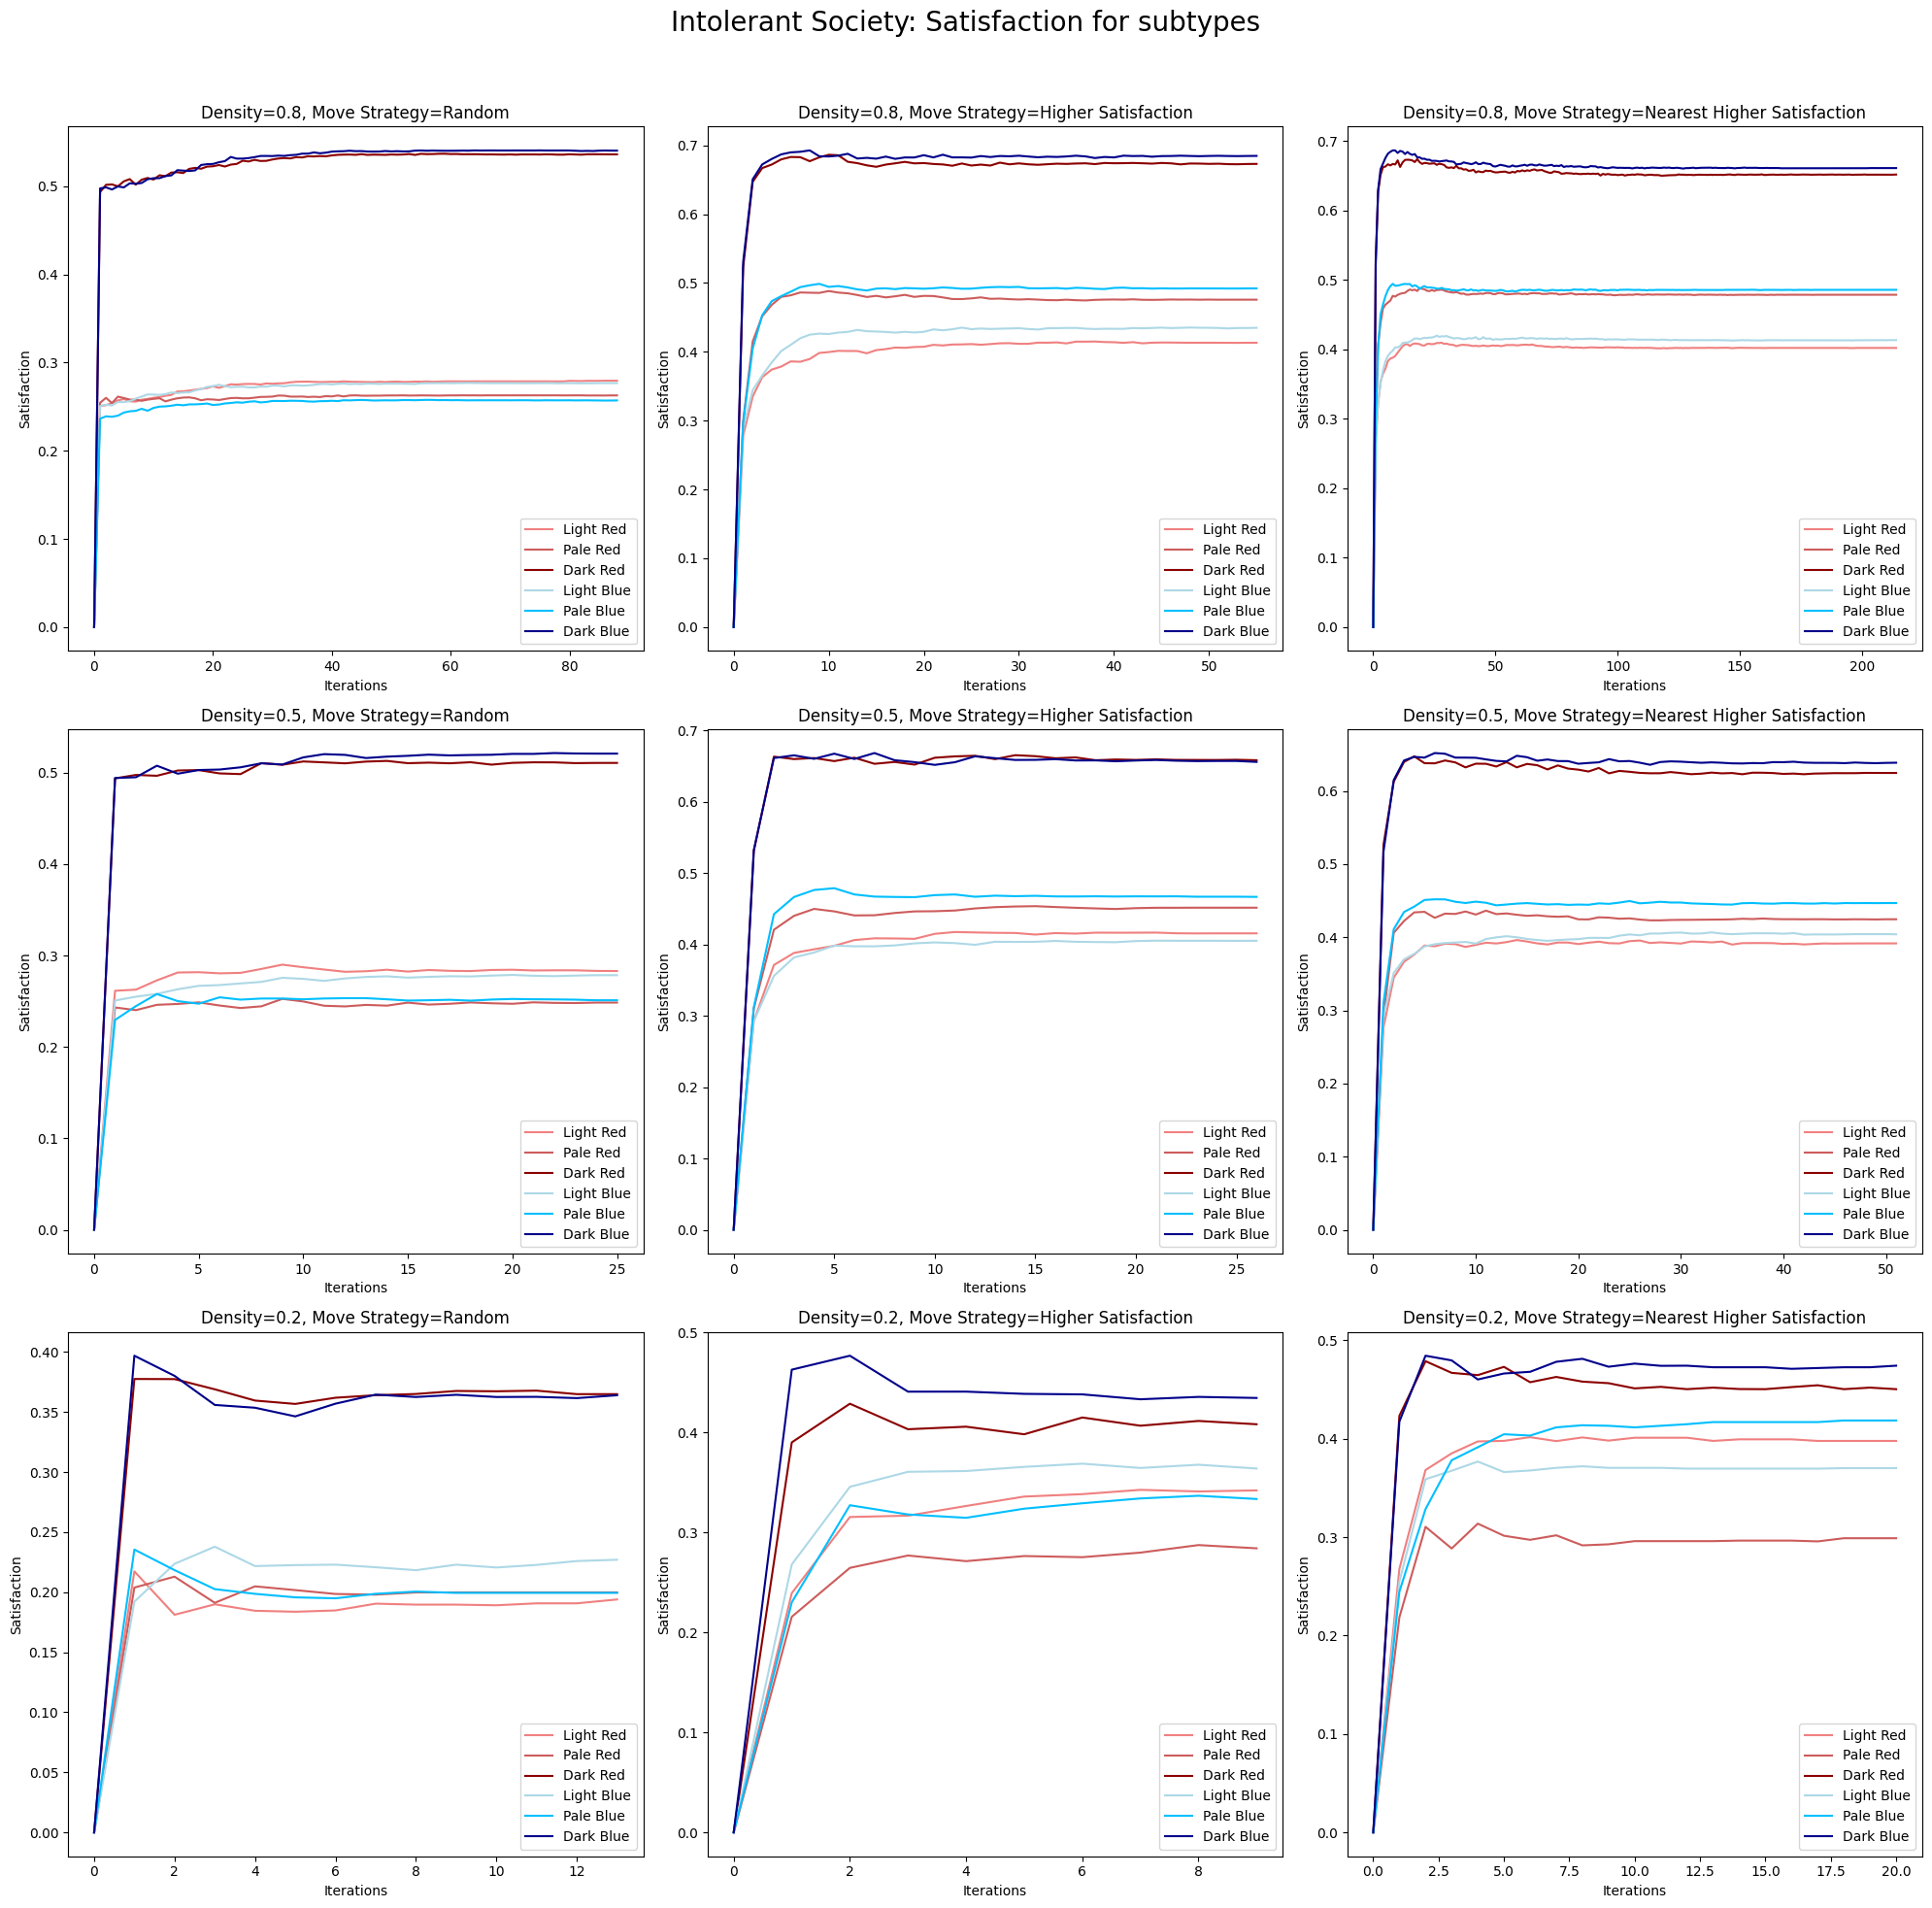

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))  
society_type = "Intolerant"  # 

fig.suptitle(f"{society_type} Society: Satisfaction for subtypes", fontsize=20)

for i, density in enumerate(densities):
    for j, move_strategy in enumerate(move_strategies):
        
        ax = axes[i, j]
        key = (density, society_type, move_strategy)
        
        
        if key in RESULTS:
            
            satisfaction_avg_subtypes = RESULTS[key]["satisfaction_avg_subtypes"]
            
            # Plot satisfaction for each subtype assuming the order: [Light Red, Pale Red, Dark Red, Light Blue, Pale Blue, Dark Blue]
            ax.plot(satisfaction_avg_subtypes[:, 0], label="Light Red", color='lightcoral')
            ax.plot(satisfaction_avg_subtypes[:, 1], label="Pale Red", color='indianred')
            ax.plot(satisfaction_avg_subtypes[:, 2], label="Dark Red", color='darkred')
            ax.plot(satisfaction_avg_subtypes[:, 3], label="Light Blue", color='lightblue')
            ax.plot(satisfaction_avg_subtypes[:, 4], label="Pale Blue", color='deepskyblue')
            ax.plot(satisfaction_avg_subtypes[:, 5], label="Dark Blue", color='darkblue')
        else:
            print(f"Warning: Key {key} not found in RESULTS")

        ax.set_title(f"Density={density}, Move Strategy={move_strategy}")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Satisfaction")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


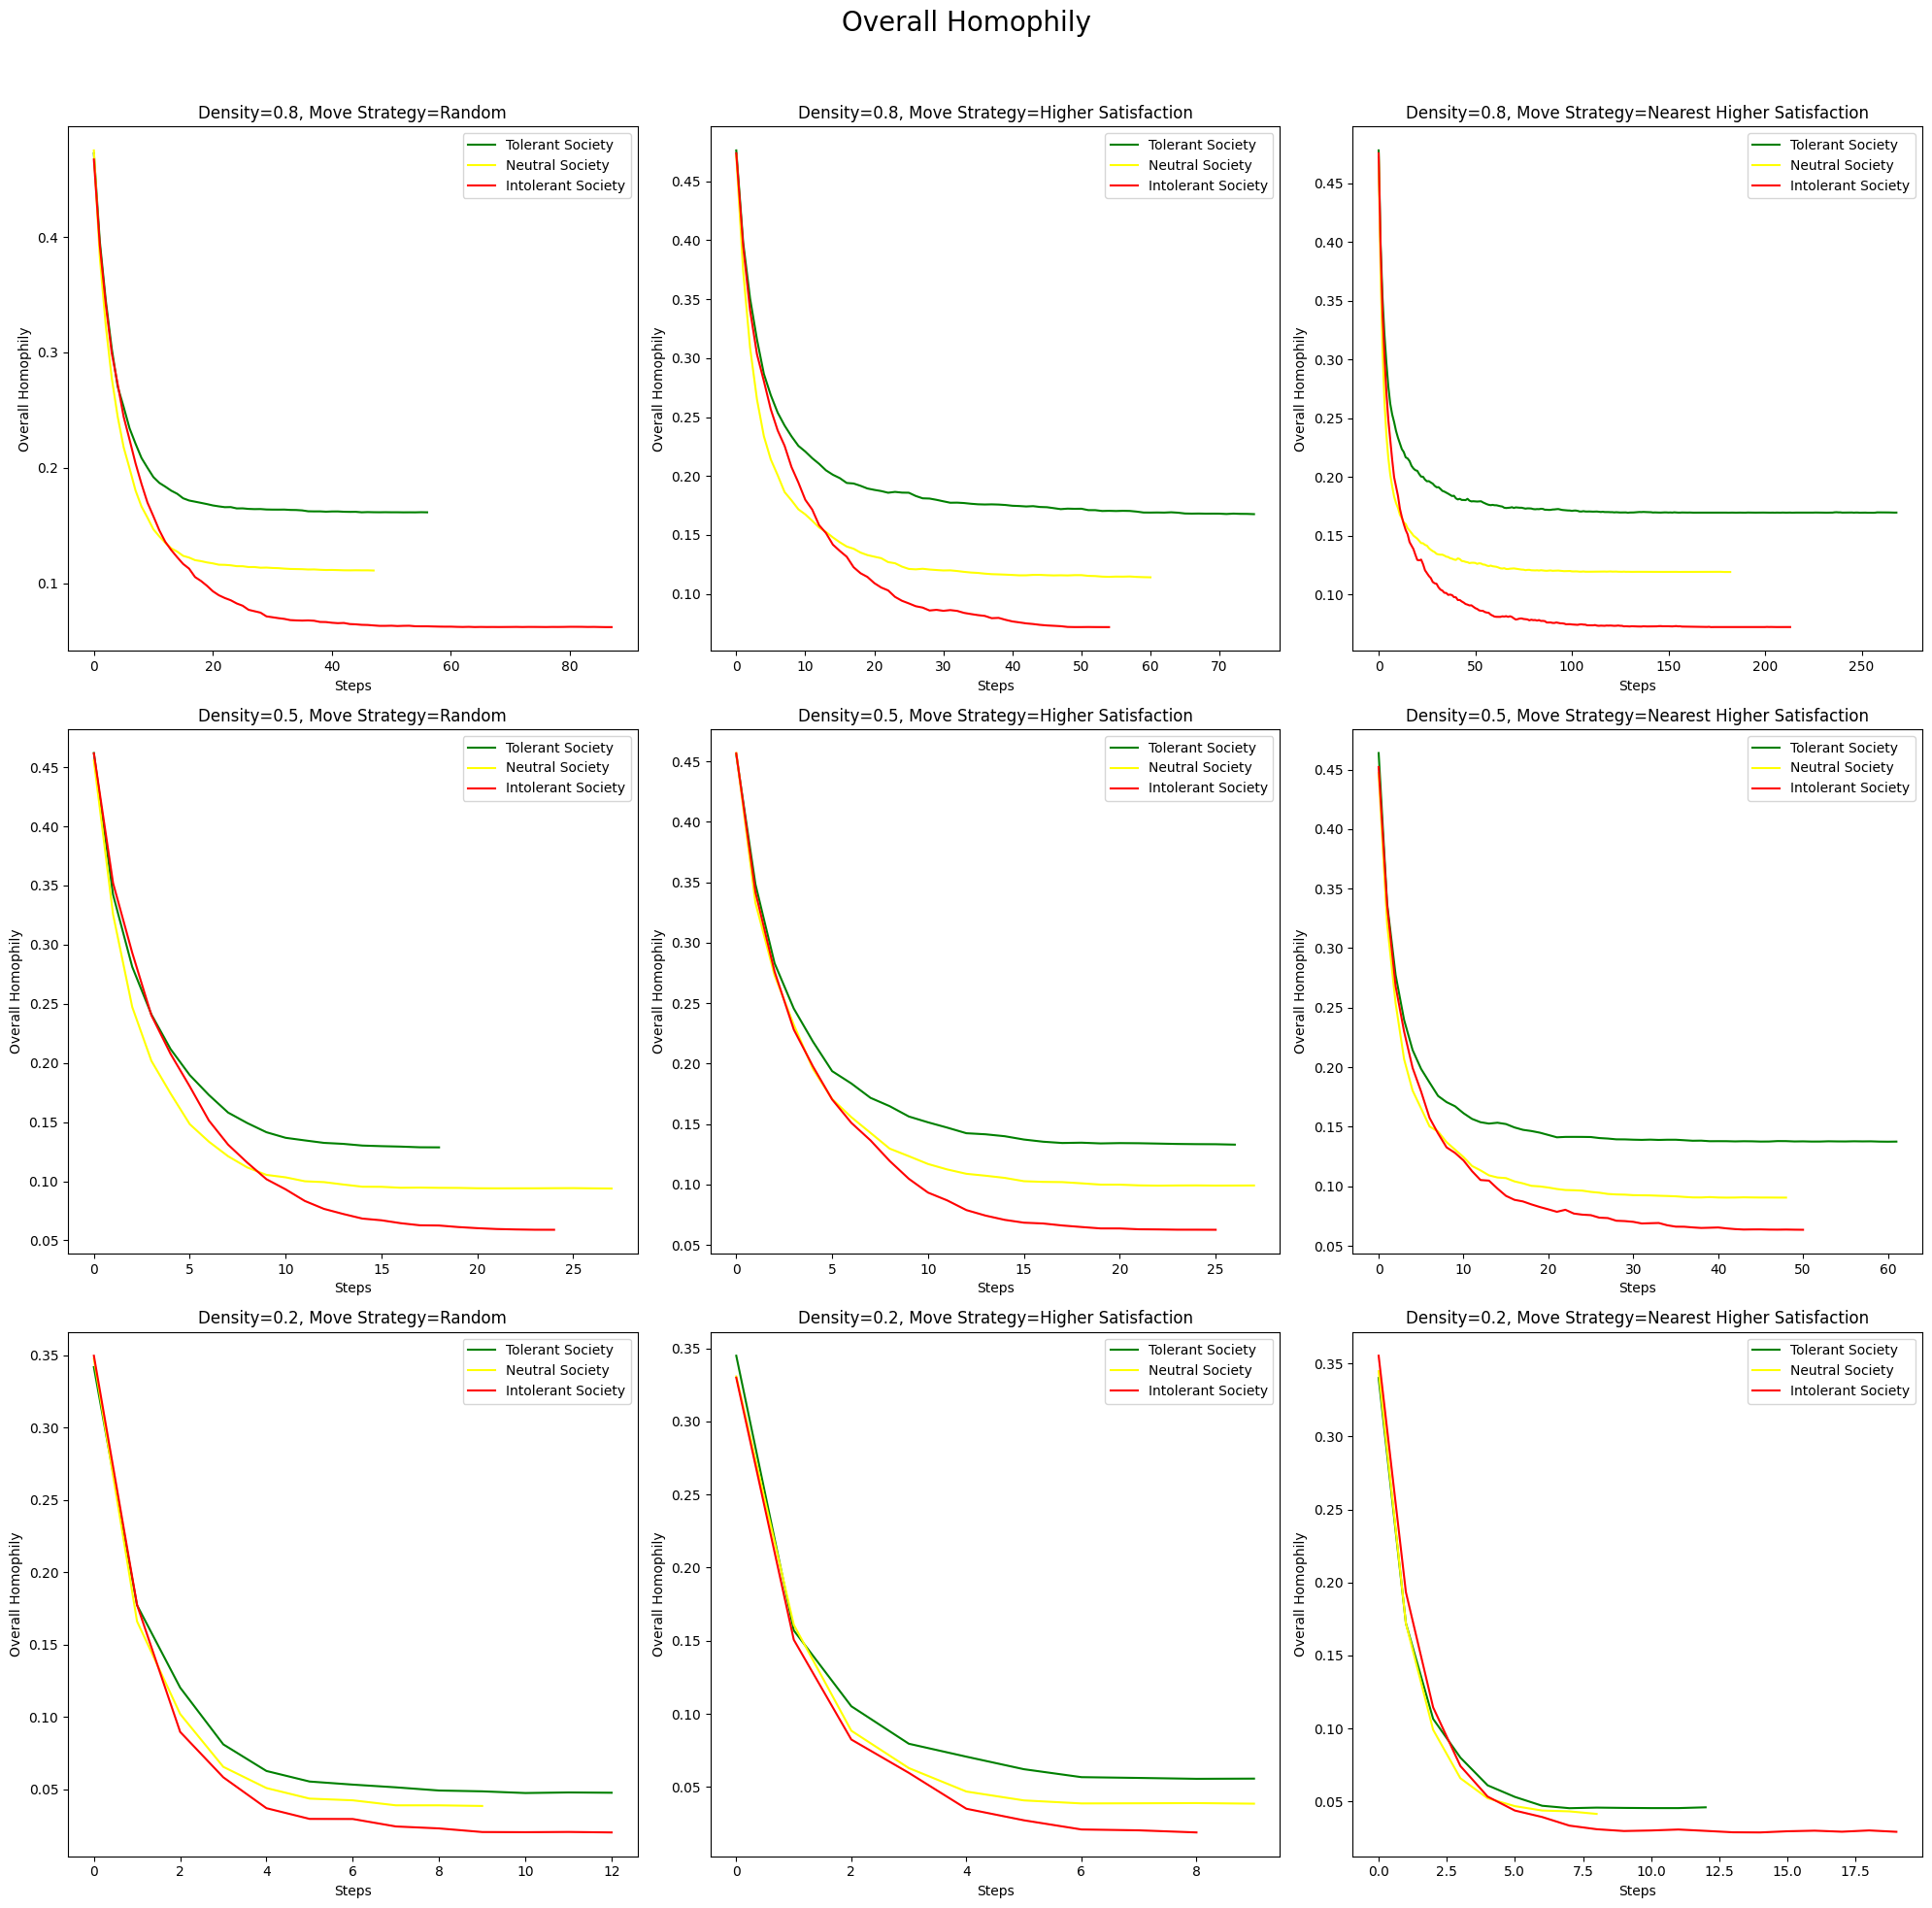

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("Overall Homophily", fontsize=20)


society_colors = {
    "Tolerant": "green",
    "Neutral": "yellow",
    "Intolerant": "red"
}

for i, density in enumerate(densities):
    for j, move_strategy in enumerate(move_strategies):
        
        ax = axes[i, j]
        for society_type in society_types:
            key = (density, society_type, move_strategy)
            
            if key in RESULTS:
                
                homophily_avg = RESULTS[key]["avg_overall_homophily"]
                
                ax.plot(homophily_avg[1:], label=f"{society_type} Society", color=society_colors[society_type])
        
        ax.set_title(f"Density={density}, Move Strategy={move_strategy}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Overall Homophily")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


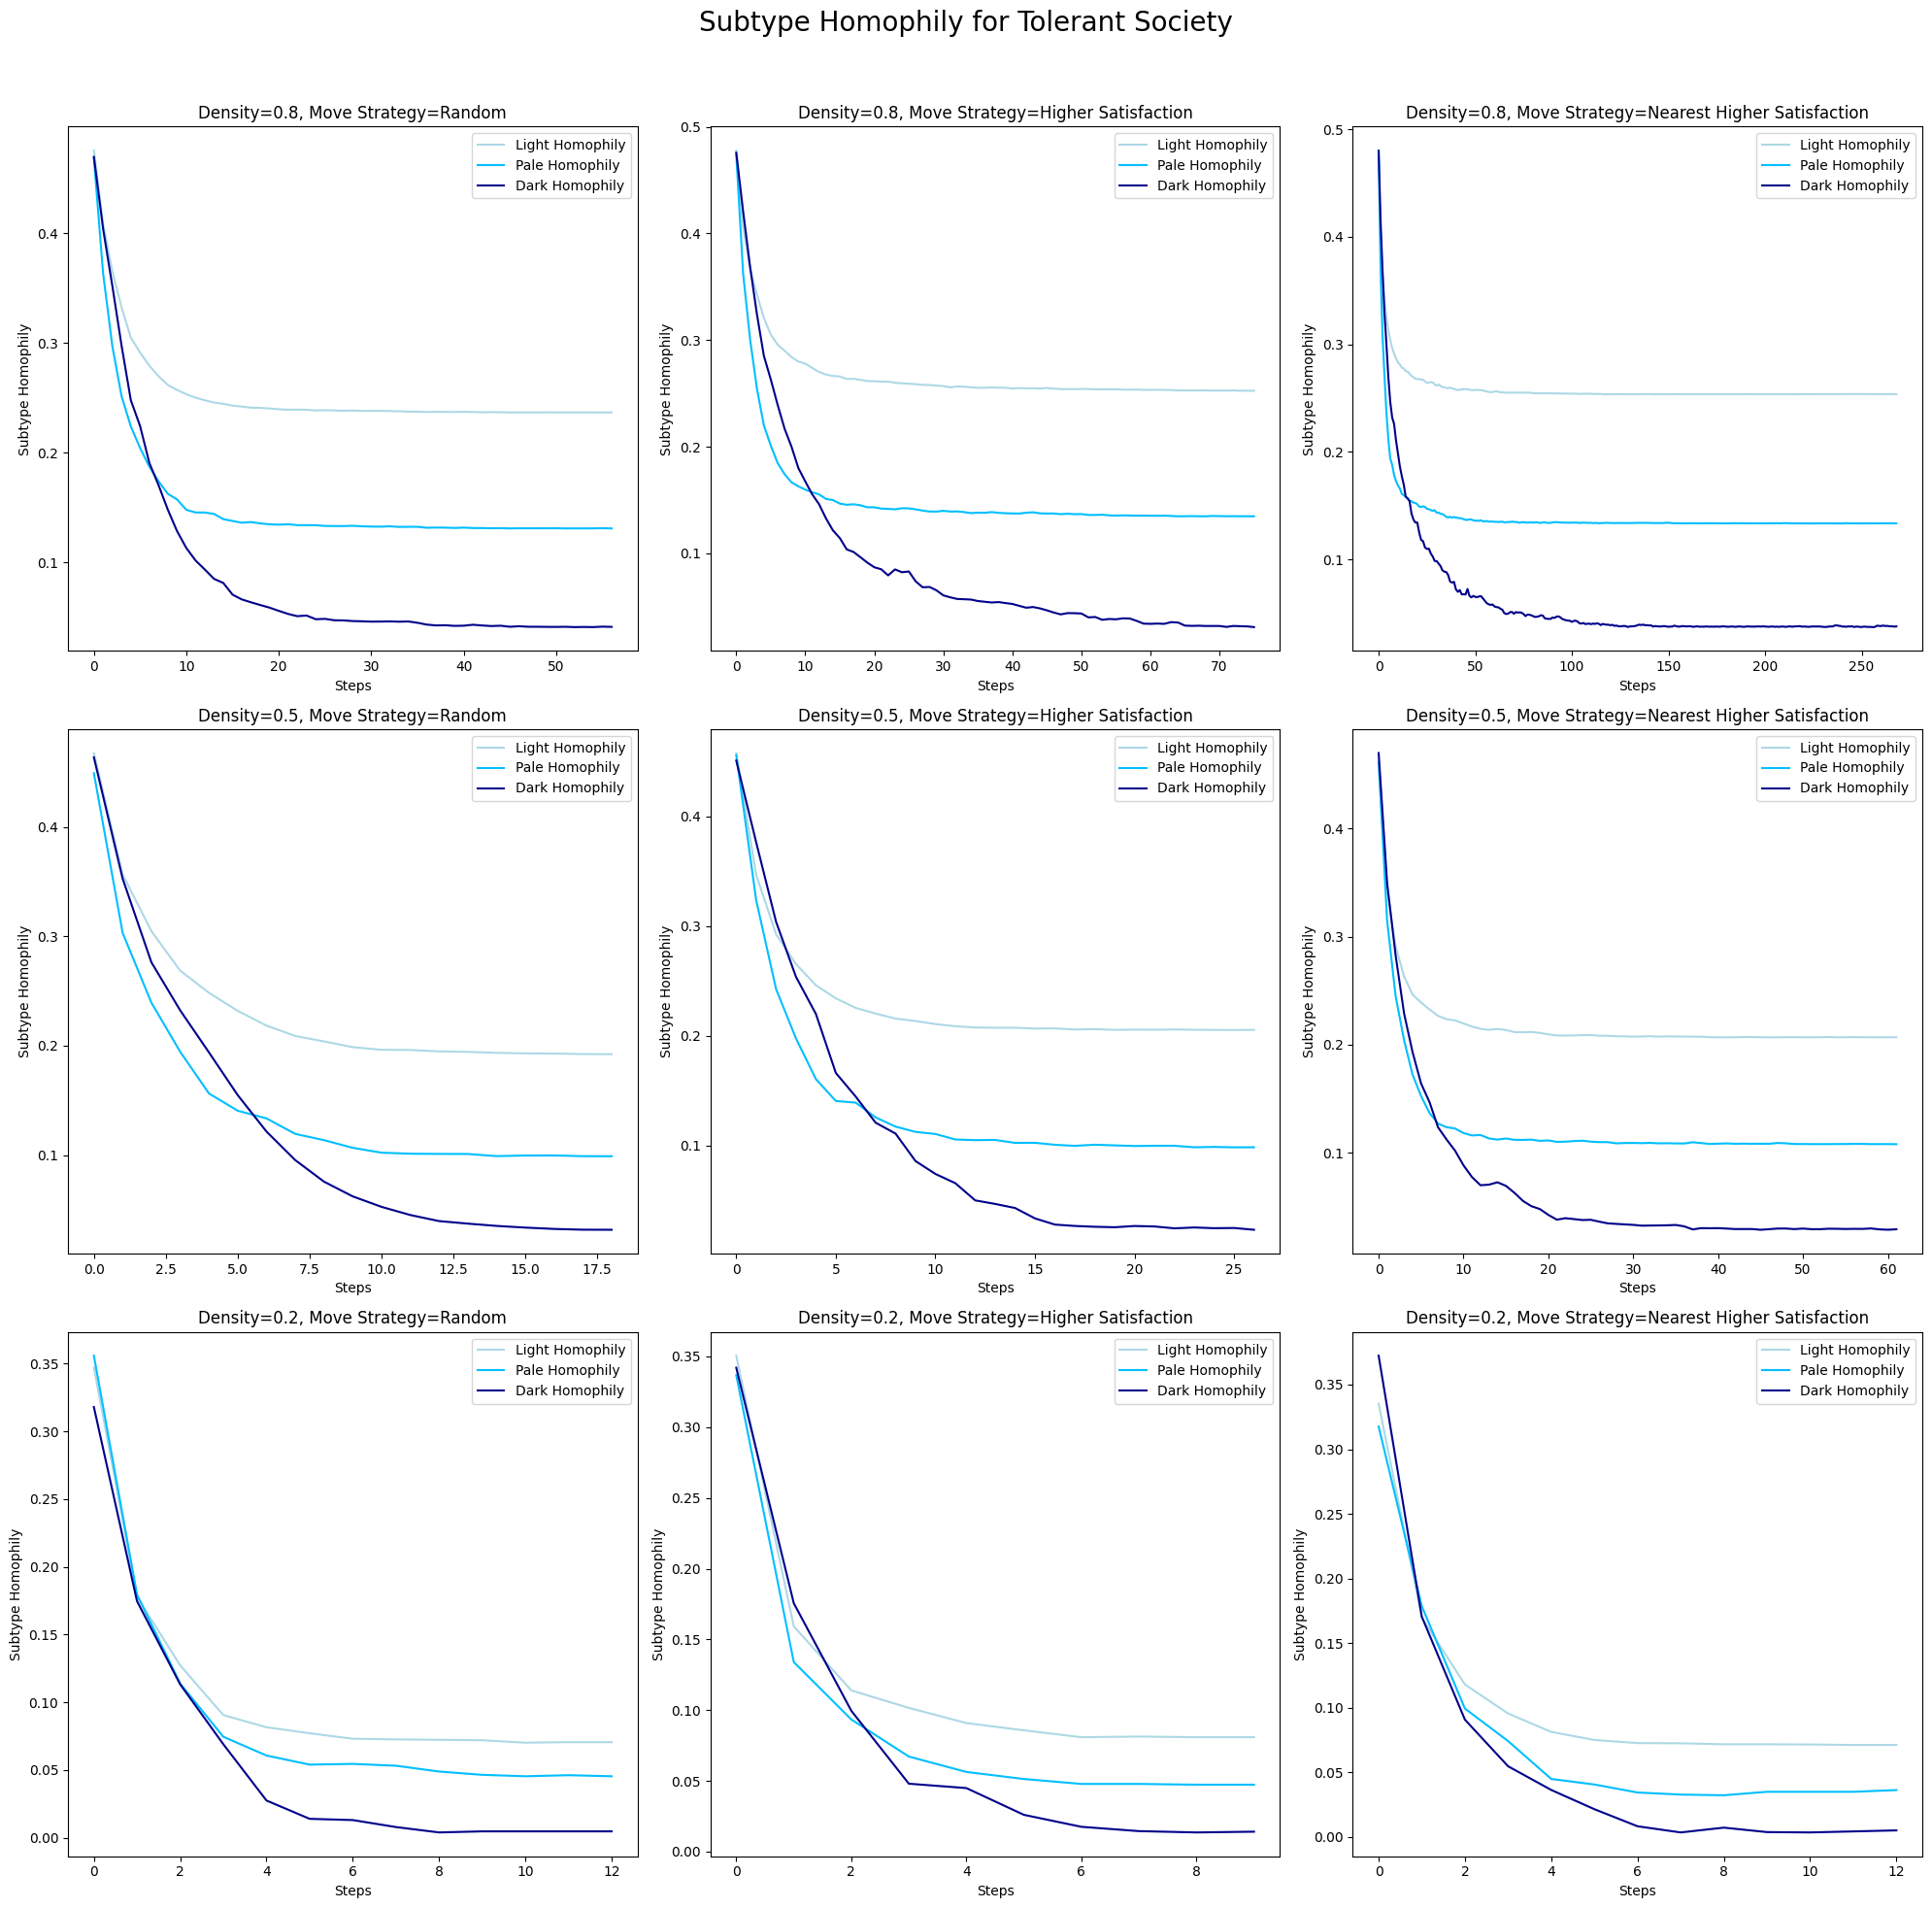

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("Subtype Homophily for Tolerant Society", fontsize=20)


subtype_colors = {
    "Light Homophily": "lightblue",
    "Pale Homophily": "deepskyblue",
    "Dark Homophily": "darkblue"
}


for i, density in enumerate(densities):
    for j, move_strategy in enumerate(move_strategies):
        
        ax = axes[i, j]
        key = (density, "Tolerant", move_strategy)
        
        if key in RESULTS:
            
            subtype_homophily_avg = RESULTS[key]["avg_subtype_homophily"]
            
            
            ax.plot(subtype_homophily_avg[1:, 0], label="Light Homophily", color=subtype_colors["Light Homophily"])
            ax.plot(subtype_homophily_avg[1:, 1], label="Pale Homophily", color=subtype_colors["Pale Homophily"])
            ax.plot(subtype_homophily_avg[1:, 2], label="Dark Homophily", color=subtype_colors["Dark Homophily"])
        
        ax.set_title(f"Density={density}, Move Strategy={move_strategy}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Subtype Homophily")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


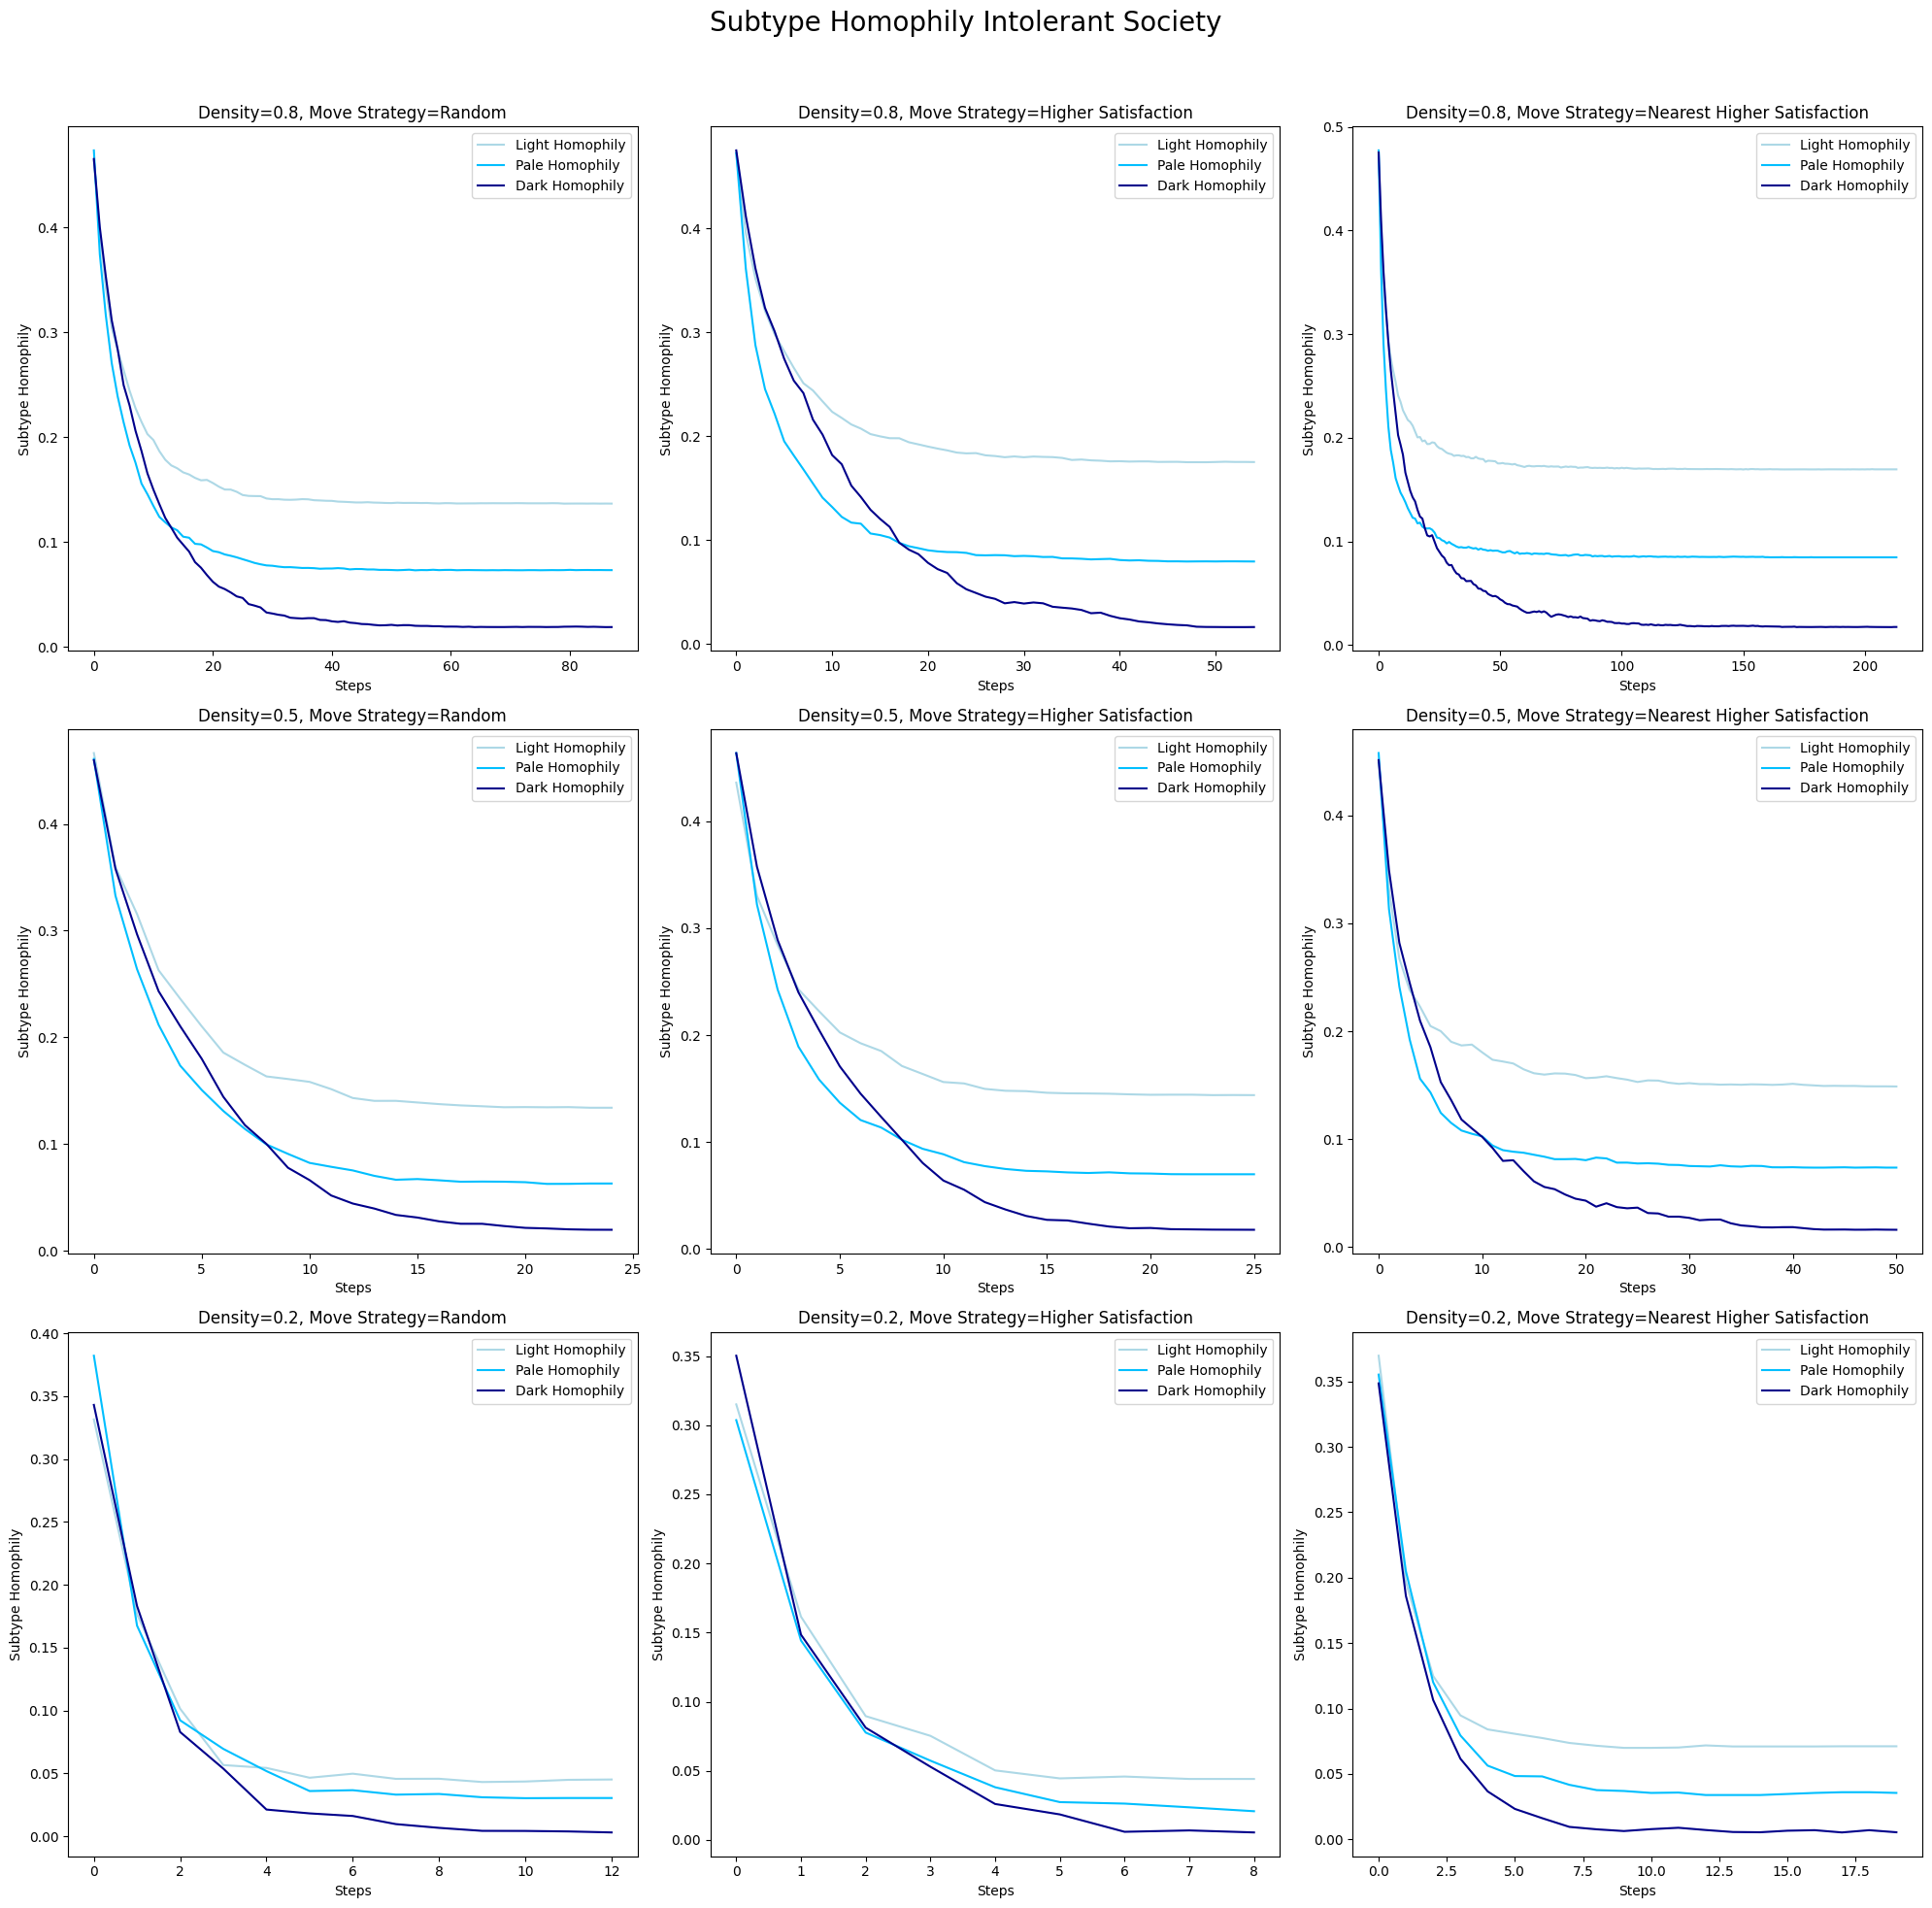

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle("Subtype Homophily Intolerant Society", fontsize=20)


subtype_colors = {
    "Light Homophily": "lightblue",
    "Pale Homophily": "deepskyblue",
    "Dark Homophily": "darkblue"
}


for i, density in enumerate(densities):
    for j, move_strategy in enumerate(move_strategies):
        
        ax = axes[i, j]
        key = (density, "Intolerant", move_strategy)
        
        if key in RESULTS:
            
            subtype_homophily_avg = RESULTS[key]["avg_subtype_homophily"]
            
            
            ax.plot(subtype_homophily_avg[1:, 0], label="Light Homophily", color=subtype_colors["Light Homophily"])
            ax.plot(subtype_homophily_avg[1:, 1], label="Pale Homophily", color=subtype_colors["Pale Homophily"])
            ax.plot(subtype_homophily_avg[1:, 2], label="Dark Homophily", color=subtype_colors["Dark Homophily"])
        
        ax.set_title(f"Density={density}, Move Strategy={move_strategy}")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Subtype Homophily")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Corner and Edge Agent's Sastisfaction

/var/folders/3d/4t5mpx4178q5kz077_nwddy40000gn/T/ipykernel_47148/3969220892.py:3: DeprecationWarning: unique ids are assigned automatically to Agents in Mesa 3. The use of custom unique_id is deprecated. Only input a model when calling `super()__init__(model)`. The unique_id inputted is not used.
  super().__init__(unique_id, model)


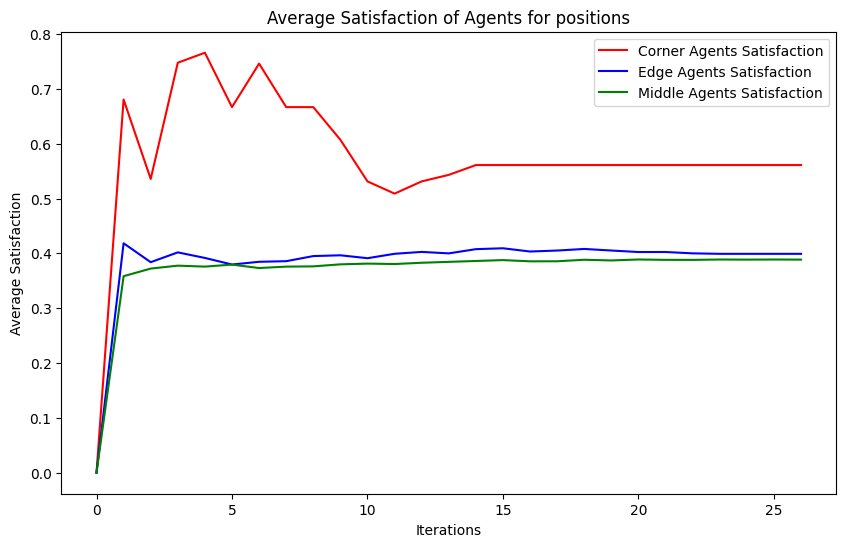

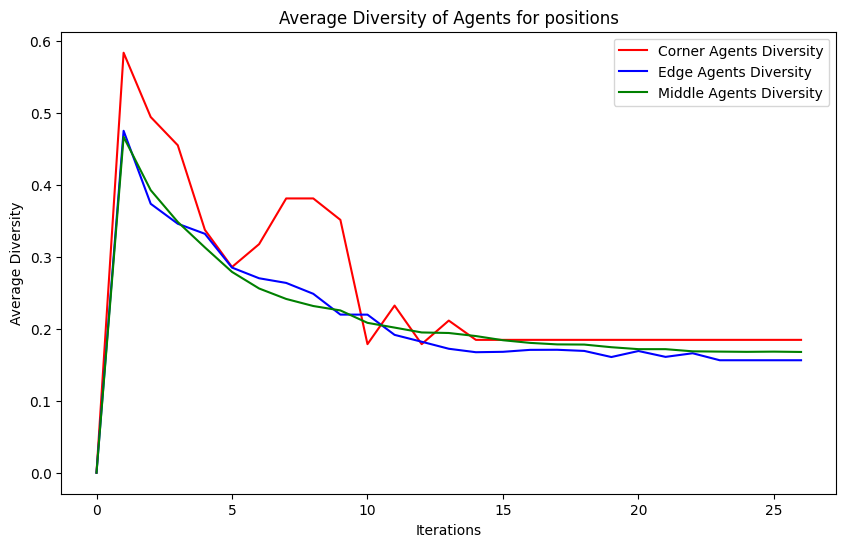

In [15]:
width = 50
height = 50
density = 0.8
society_type = "Tolerant"
move_strategy = "Random"
iterations = 1000


model = SchellingModel(width, height, density, society_type, move_strategy)

def categorize_position(x, y, width, height):
    # Corners
    if (x == 0 and y == 0) or (x == 0 and y == height-1) or (x == width-1 and y == 0) or (x == width-1 and y == height-1):
        return 'corner'
    # Edges (excluding corners)
    elif x == 0 or y == 0 or x == width-1 or y == height-1:
        return 'edge'
    # Middle
    else:
        return 'middle'


corner_avg_satisfaction = []
edge_avg_satisfaction = []
middle_avg_satisfaction = []

corner_avg_diversity = []
edge_avg_diversity = []
middle_avg_diversity = []


for step in range(iterations):
    
    corner_satisfaction_step = []
    edge_satisfaction_step = []
    middle_satisfaction_step = []
    
    corner_diversity_step = []
    edge_diversity_step = []
    middle_diversity_step = []

    
    for agent in model.schedule.agents:
        x, y = agent.pos
        position_category = categorize_position(x, y, width, height)
        
        if position_category == 'corner':
            corner_satisfaction_step.append(agent.satisfaction)
            corner_diversity_step.append(agent.diversity)  
        elif position_category == 'edge':
            edge_satisfaction_step.append(agent.satisfaction)
            edge_diversity_step.append(agent.diversity)  
        else:
            middle_satisfaction_step.append(agent.satisfaction)
            middle_diversity_step.append(agent.diversity)  

    
    avg_corner_satisfaction = np.mean(corner_satisfaction_step) if corner_satisfaction_step else 0
    avg_edge_satisfaction = np.mean(edge_satisfaction_step) if edge_satisfaction_step else 0
    avg_middle_satisfaction = np.mean(middle_satisfaction_step) if middle_satisfaction_step else 0
    
    avg_corner_diversity = np.mean(corner_diversity_step) if corner_diversity_step else 0
    avg_edge_diversity = np.mean(edge_diversity_step) if edge_diversity_step else 0
    avg_middle_diversity = np.mean(middle_diversity_step) if middle_diversity_step else 0

   
    corner_avg_satisfaction.append(avg_corner_satisfaction)
    edge_avg_satisfaction.append(avg_edge_satisfaction)
    middle_avg_satisfaction.append(avg_middle_satisfaction)

    corner_avg_diversity.append(avg_corner_diversity)
    edge_avg_diversity.append(avg_edge_diversity)
    middle_avg_diversity.append(avg_middle_diversity)

 
    model.step()

  
    if not model.moved:
        break


plt.figure(figsize=(10, 6))
plt.plot(corner_avg_satisfaction, label="Corner Agents Satisfaction", color="red")
plt.plot(edge_avg_satisfaction, label="Edge Agents Satisfaction", color="blue")
plt.plot(middle_avg_satisfaction, label="Middle Agents Satisfaction", color="green")

plt.title("Average Satisfaction of Agents for positions")
plt.xlabel("Iterations")
plt.ylabel("Average Satisfaction")
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(corner_avg_diversity, label="Corner Agents Diversity", color="red")
plt.plot(edge_avg_diversity, label="Edge Agents Diversity", color="blue")
plt.plot(middle_avg_diversity, label="Middle Agents Diversity", color="green")

plt.title("Average Diversity of Agents for positions")
plt.xlabel("Iterations")
plt.ylabel("Average Diversity")
plt.legend()
plt.show()